In [3]:
import pandas as pd
import os

# Define the path to your dataset
dataset_path = os.path.join('data', 'test.csv')

try:
    # --- CHANGE MADE HERE: Added encoding='latin1' ---
    df = pd.read_csv(dataset_path, encoding='latin1')
    print(f"Dataset loaded successfully from: {dataset_path}")
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of columns: {df.shape[1]}")
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
    print("\nColumn names:")
    print(df.columns)
    print("\nMissing values per column:")
    print(df.isnull().sum())

except FileNotFoundError:
    print(f"Error: The file '{dataset_path}' was not found.")
    print("Please ensure 'test.csv' is in a 'data' folder, or update the 'dataset_path' variable.")
except Exception as e:
    # This will now catch the UnicodeDecodeError if 'latin1' also fails
    print(f"An error occurred during file loading: {e}")
    print("This might be an encoding issue. Try a different encoding like 'ISO-8859-1' or 'cp1252'.")

# IMPORTANT: Based on your screenshot, these are the correct column names.
text_column_name = 'text'
sentiment_column_name = 'sentiment'

# Let's rename them to 'text' and 'sentiment' for consistency throughout our code
if 'df' in locals() and text_column_name in df.columns and sentiment_column_name in df.columns:
    df.rename(columns={text_column_name: 'text', sentiment_column_name: 'sentiment'}, inplace=True)
    print(f"\nColumns renamed to 'text' and 'sentiment'.")
    print(df[['text', 'sentiment']].head())
    print("\nUnique sentiment labels (before any mapping):")
    print(df['sentiment'].unique())
else:
    # This message will only show if df wasn't created, or columns aren't found after successful load
    print(f"Error: DataFrame 'df' was not created, or could not find '{text_column_name}' or '{sentiment_column_name}' columns after loading.")
    print("Please check your 'test.csv' and update 'text_column_name' and 'sentiment_column_name' if they are different.")

Dataset loaded successfully from: data\test.csv
Number of rows: 4815
Number of columns: 9

First 5 rows of the dataset:
       textID                                               text sentiment  \
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral   
1  96d74cb729   Shanghai is also really exciting (precisely -...  positive   
2  eee518ae67  Recession hit Veronique Branquinho, she has to...  negative   
3  01082688c6                                        happy bday!  positive   
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!  positive   

  Time of Tweet Age of User      Country  Population -2020  Land Area (Km²)  \
0       morning        0-20  Afghanistan        38928346.0         652860.0   
1          noon       21-30      Albania         2877797.0          27400.0   
2         night       31-45      Algeria        43851044.0        2381740.0   
3       morning       46-60      Andorra           77265.0            470.0   
4          noon 

In [7]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# You don't need to import pandas again if you've already run 2.1 in the same session/notebook

# --- Download NLTK data (run these lines ONCE EVER on your machine if needed) ---
# This block attempts to download necessary NLTK datasets.
# It's crucial for the preprocessing steps.
try:
    # Check if 'stopwords' resource is found
    nltk.data.find('corpora/stopwords')
except LookupError: # Corrected: Catch LookupError when resource is not found
    print("NLTK 'stopwords' not found. Downloading...")
    nltk.download('stopwords')
    print("NLTK 'stopwords' downloaded successfully.")

try:
    # Check if 'wordnet' resource is found
    nltk.data.find('corpora/wordnet')
except LookupError: # Corrected: Catch LookupError
    print("NLTK 'wordnet' not found. Downloading...")
    nltk.download('wordnet')
    print("NLTK 'wordnet' downloaded successfully.")

try:
    # Check if 'omw-1.4' (Open Multilingual Wordnet) resource is found
    nltk.data.find('corpora/omw-1.4')
except LookupError: # Corrected: Catch LookupError
    print("NLTK 'omw-1.4' not found. Downloading...")
    nltk.download('omw-1.4')
    print("NLTK 'omw-1.4' downloaded successfully.")
# ----------------------------------------------------------------------


# Initialize NLTK components
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Cleans and preprocesses a given text string from social media comments.

    Args:
        text (str): The input text comment from the 'text' column.

    Returns:
        str: The cleaned and preprocessed text.
    """
    if not isinstance(text, str): # Handle potential non-string entries (e.g., NaN, if any somehow remain)
        return ""

    text = text.lower() # 1. Convert to lowercase

    # 2. Remove URLs (http, https, www)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 3. Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)

    # 4. Remove hashtag symbol (#) but keep the word (e.g., #awesome -> awesome)
    text = re.sub(r'#', '', text)

    # 5. Remove punctuation (using string.punctuation for common ones)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 6. Remove numbers (e.g., "product123" -> "product")
    text = re.sub(r'\d+', '', text)

    # 7. Remove extra whitespace (e.g., "  hello   world  " -> "hello world")
    text = re.sub(r'\s+', ' ', text).strip()

    # 8. Tokenization (splitting text into individual words)
    # We'll use a simple space split after cleaning for efficiency
    tokens = text.split()

    # 9. Remove stopwords and apply Lemmatization
    cleaned_tokens = []
    for token in tokens:
        if token not in stop_words:
            # Lemmatize the token (e.g., "running" -> "run", "better" -> "good")
            cleaned_tokens.append(lemmatizer.lemmatize(token))

    return " ".join(cleaned_tokens) # Join tokens back into a single string

# Apply the preprocessing function to your 'text' column
print("Applying text preprocessing to the 'text' column. This might take a moment...")
df['cleaned_text'] = df['text'].apply(preprocess_text)

print("\n--- Preprocessing Complete ---")
print("Original vs. Cleaned Text Examples (first 5 rows):")
for i in range(min(5, len(df))): # Ensure we don't try to access more rows than exist
    print(f"Original: {df['text'].iloc[i]}")
    print(f"Cleaned:  {df['cleaned_text'].iloc[i]}\n")

# Handle rows where 'cleaned_text' might have become empty after cleaning
original_rows = len(df)
df.replace('', pd.NA, inplace=True) # Replace empty strings with NaN
df.dropna(subset=['cleaned_text'], inplace=True) # Drop rows where 'cleaned_text' is NaN
rows_dropped = original_rows - len(df)

print(f"\nNumber of rows before dropping empty cleaned texts: {original_rows}")
print(f"Number of rows dropped (comments that became empty after cleaning): {rows_dropped}")
print(f"Number of rows after dropping empty cleaned texts: {df.shape[0]}")
print(f"Sample of cleaned data with original and sentiment columns:\n{df[['text', 'cleaned_text', 'sentiment']].head()}")

NLTK 'stopwords' not found. Downloading...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pkv23\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pkv23\AppData\Roaming\nltk_data...


NLTK 'stopwords' downloaded successfully.
NLTK 'wordnet' not found. Downloading...
NLTK 'wordnet' downloaded successfully.
NLTK 'omw-1.4' not found. Downloading...


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pkv23\AppData\Roaming\nltk_data...


NLTK 'omw-1.4' downloaded successfully.
Applying text preprocessing to the 'text' column. This might take a moment...

--- Preprocessing Complete ---
Original vs. Cleaned Text Examples (first 5 rows):
Original: Last session of the day  http://twitpic.com/67ezh
Cleaned:  last session day

Original:  Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China:  (SH)  (BJ).
Cleaned:  shanghai also really exciting precisely skyscraper galore good tweeps china sh bj

Original: Recession hit Veronique Branquinho, she has to quit her company, such a shame!
Cleaned:  recession hit veronique branquinho quit company shame

Original:  happy bday!
Cleaned:  happy bday

Original:  http://twitpic.com/4w75p - I like it!!
Cleaned:  like


Number of rows before dropping empty cleaned texts: 4815
Number of rows dropped (comments that became empty after cleaning): 1293
Number of rows after dropping empty cleaned texts: 3522
Sample of cleaned data with original and sentiment c

In [9]:
# No new imports needed if you're running this in the same notebook session

# Identify unique sentiment labels from your dataset
# This should confirm ['neutral', 'positive', 'negative'] or similar based on your data
unique_sentiments = df['sentiment'].unique()
print(f"\nUnique sentiment labels identified: {unique_sentiments}")

# Define the mapping dictionary based on your identified unique labels
# This mapping is standard: Negative=0, Neutral=1, Positive=2
sentiment_mapping = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

# IMPORTANT: Ensure all unique sentiments in your data are covered by this mapping.
# If there are any other unexpected labels, they will be dropped by the next filter.

# First, filter out any sentiment labels that are not in your mapping.
# This ensures that only the sentiments we want to classify are kept.
# .copy() is used to prevent a SettingWithCopyWarning in Pandas.
original_rows_before_sentiment_filter = len(df)
df = df[df['sentiment'].isin(sentiment_mapping.keys())].copy()
rows_dropped_sentiment_filter = original_rows_before_sentiment_filter - len(df)

if rows_dropped_sentiment_filter > 0:
    print(f"Warning: {rows_dropped_sentiment_filter} rows were dropped because their sentiment label was not in the defined mapping ({sentiment_mapping.keys()}).")

# Apply the mapping to create a new numerical sentiment column
df['sentiment_numerical'] = df['sentiment'].map(sentiment_mapping)

print("\n--- Sentiment Mapping Complete ---")
print("Sentiment labels mapped to numerical values:")
# Display a sample of original and numerical sentiment labels
print(df[['sentiment', 'sentiment_numerical']].head())
print("\nValue counts for numerical sentiments (distribution of categories):")
print(df['sentiment_numerical'].value_counts())

# Check if there are any NaN values introduced in the numerical sentiment column
if df['sentiment_numerical'].isnull().any():
    print("\nWarning: NaN values found in 'sentiment_numerical' after mapping. This indicates unmapped sentiment labels.")
    print(df[df['sentiment_numerical'].isnull()])


Unique sentiment labels identified: ['neutral' 'positive' 'negative']

--- Sentiment Mapping Complete ---
Sentiment labels mapped to numerical values:
  sentiment  sentiment_numerical
0   neutral                    1
1  positive                    2
2  negative                    0
3  positive                    2
4  positive                    2

Value counts for numerical sentiments (distribution of categories):
sentiment_numerical
1    1419
2    1103
0    1000
Name: count, dtype: int64


In [11]:
# No new imports needed here.

# Define the path where you want to save your cleaned dataset
# This will create a file named 'cleaned_social_media_comments.csv' inside your 'data' folder
cleaned_dataset_path = os.path.join('data', 'cleaned_social_media_comments.csv')

# Save the DataFrame to a new CSV file
# We'll only save the 'cleaned_text' and 'sentiment_numerical' columns,
# as these are the main columns you will use for machine learning.
# index=False prevents pandas from writing the DataFrame index as a column in the CSV.
df[['cleaned_text', 'sentiment_numerical']].to_csv(cleaned_dataset_path, index=False)

print(f"\n--- Cleaned Data Saved Successfully ---")
print(f"Cleaned data saved to: {cleaned_dataset_path}")
print(f"Final shape of your cleaned dataset (rows, columns): {df.shape}")

# Optional: Load the saved file back to quickly verify its contents
print("\nFirst 5 rows of the saved cleaned data file (for verification):")
try:
    df_cleaned_check = pd.read_csv(cleaned_dataset_path)
    print(df_cleaned_check.head())
except Exception as e:
    print(f"Error verifying saved file: {e}")


--- Cleaned Data Saved Successfully ---
Cleaned data saved to: data\cleaned_social_media_comments.csv
Final shape of your cleaned dataset (rows, columns): (3522, 11)

First 5 rows of the saved cleaned data file (for verification):
                                        cleaned_text  sentiment_numerical
0                                   last session day                    1
1  shanghai also really exciting precisely skyscr...                    2
2  recession hit veronique branquinho quit compan...                    0
3                                         happy bday                    2
4                                               like                    2


In [13]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Define the path to your cleaned dataset
cleaned_dataset_path = os.path.join('data', 'cleaned_social_media_comments.csv')

try:
    # Load the cleaned data
    df_cleaned = pd.read_csv(cleaned_dataset_path)
    print(f"Cleaned data loaded successfully from: {cleaned_dataset_path}")
    print(f"Shape of cleaned data: {df_cleaned.shape}")
    print("First 5 rows of cleaned data:")
    print(df_cleaned.head())

except FileNotFoundError:
    print(f"Error: The cleaned dataset file was not found at '{cleaned_dataset_path}'.")
    print("Please ensure you completed Step 2.4 and the file exists.")
except Exception as e:
    print(f"An error occurred while loading the cleaned dataset: {e}")

# Separate features (X) and target (y)
# X will be the cleaned text, y will be the numerical sentiment
X = df_cleaned['cleaned_text']
y = df_cleaned['sentiment_numerical']

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"Sample X (first 5 comments):\n{X.head()}")
print(f"Sample y (first 5 sentiments):\n{y.head()}")

# Initialize the TF-IDF Vectorizer
# max_features: Limits the number of features (words) to consider, common for reducing dimensionality.
# min_df: Ignores words that appear in less than X documents.
# max_df: Ignores words that appear in more than X% of the documents (e.g., very common words).
# ngram_range: (1,1) for single words, (1,2) for single words and 2-word phrases (bigrams).
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7, ngram_range=(1,2))

print("\nFitting and transforming text data using TF-IDF Vectorizer...")
# Fit and transform the text data
# .fit() learns the vocabulary from the text
# .transform() converts the text into TF-IDF vectors
X_vectorized = tfidf_vectorizer.fit_transform(X)

print(f"TF-IDF Vectorization complete.")
print(f"Shape of vectorized features (X_vectorized): {X_vectorized.shape}")
print(f"Number of features (unique words/ngrams) extracted: {X_vectorized.shape[1]}")

# X_vectorized is a sparse matrix to save memory. You can convert it to a dense array for inspection,
# but usually, ML models work directly with sparse matrices.
# print("\nFirst 5 rows of vectorized features (dense array for viewing, usually kept sparse):")
# print(X_vectorized[:5].toarray())

# You can inspect some of the feature names (words/ngrams) learned by the vectorizer
# print("\nSample feature names (vocabulary):")
# print(tfidf_vectorizer.get_feature_names_out()[:20])

# Now, split the data into training and testing sets
# This is crucial for evaluating your model's performance on unseen data
# test_size=0.2 means 20% of the data will be used for testing
# random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X_vectorized, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n--- Data Splitting Complete ---")
print(f"Shape of X_train (training features): {X_train.shape}")
print(f"Shape of X_test (testing features): {X_test.shape}")
print(f"Shape of y_train (training labels): {y_train.shape}")
print(f"Shape of y_test (testing labels): {y_test.shape}")
print("\nData is now vectorized and split into training and testing sets, ready for model training!")

Cleaned data loaded successfully from: data\cleaned_social_media_comments.csv
Shape of cleaned data: (3522, 2)
First 5 rows of cleaned data:
                                        cleaned_text  sentiment_numerical
0                                   last session day                    1
1  shanghai also really exciting precisely skyscr...                    2
2  recession hit veronique branquinho quit compan...                    0
3                                         happy bday                    2
4                                               like                    2

Features (X) shape: (3522,)
Target (y) shape: (3522,)
Sample X (first 5 comments):
0                                     last session day
1    shanghai also really exciting precisely skyscr...
2    recession hit veronique branquinho quit compan...
3                                           happy bday
4                                                 like
Name: cleaned_text, dtype: object
Sample y (first 5 sent

In [15]:
from sklearn.linear_model import LogisticRegression
import joblib # For saving the model later

# Initialize the Logistic Regression model
# max_iter is increased to ensure convergence for potentially large datasets
# solver='liblinear' is a good choice for smaller datasets and when using L1/L2 regularization
print("Initializing Logistic Regression model...")
model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

# Train the model using the training data
# The model learns the relationship between the TF-IDF features (X_train)
# and the numerical sentiment labels (y_train)
print("Training the Logistic Regression model. This might take a moment...")
model.fit(X_train, y_train)

print("\n--- Model Training Complete ---")
print("Logistic Regression model has been trained successfully.")

# You can optionally save the trained model to a file
# This allows you to load it later without retraining, which is very useful for deployment.
model_save_path = os.path.join('models', 'logistic_regression_sentiment_model.joblib')

# Ensure the 'models' directory exists
if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(model, model_save_path)
print(f"Trained model saved to: {model_save_path}")

# You can also save the TF-IDF vectorizer, as you'll need it to transform new text for prediction
vectorizer_save_path = os.path.join('models', 'tfidf_vectorizer.joblib')
joblib.dump(tfidf_vectorizer, vectorizer_save_path)
print(f"TF-IDF Vectorizer saved to: {vectorizer_save_path}")

Initializing Logistic Regression model...
Training the Logistic Regression model. This might take a moment...

--- Model Training Complete ---
Logistic Regression model has been trained successfully.
Trained model saved to: models\logistic_regression_sentiment_model.joblib
TF-IDF Vectorizer saved to: models\tfidf_vectorizer.joblib


Making predictions on the test set...

--- Model Evaluation Results ---
Overall Accuracy: 0.6241

Classification Report:
              precision    recall  f1-score   support

    negative     0.6562    0.5250    0.5833       200
     neutral     0.5472    0.7148    0.6198       284
    positive     0.7586    0.5973    0.6684       221

    accuracy                         0.6241       705
   macro avg     0.6540    0.6124    0.6238       705
weighted avg     0.6444    0.6241    0.6247       705


Confusion Matrix:
[[105  88   7]
 [ 46 203  35]
 [  9  80 132]]


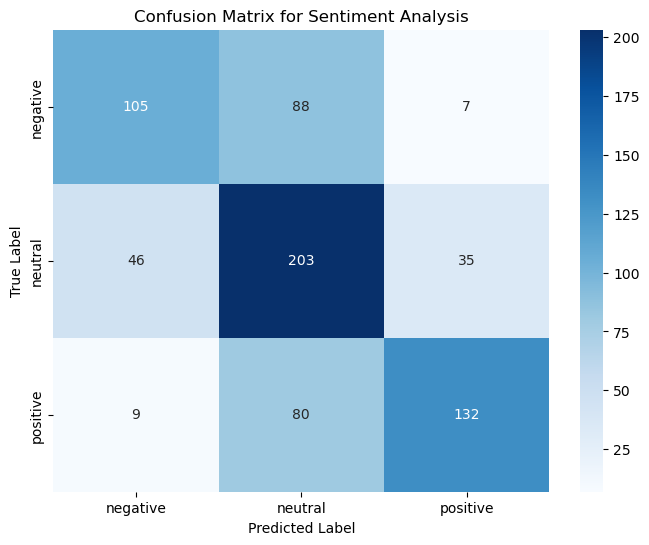


Model evaluation complete. Review the metrics to understand performance.


In [17]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # For unique labels check

# Make predictions on the test set
# The model will use the features in X_test to predict the sentiment labels
print("Making predictions on the test set...")
y_pred = model.predict(X_test)

# --- Evaluate the Model ---
print("\n--- Model Evaluation Results ---")

# 1. Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")

# 2. Classification Report
# This provides precision, recall, and F1-score for each class (0, 1, 2)
# and averages (macro avg, weighted avg).
print("\nClassification Report:")
# You'll need to define the target_names based on your sentiment_mapping
# From Step 2.3, we mapped: 'negative': 0, 'neutral': 1, 'positive': 2
target_names = ['negative', 'neutral', 'positive']

# Filter target_names to only include labels present in y_test
# This handles cases where a class might be missing in y_test after splitting
present_labels_in_y_test = np.unique(y_test)
filtered_target_names = [name for i, name in enumerate(target_names) if i in present_labels_in_y_test]

print(classification_report(y_test, y_pred, target_names=filtered_target_names, digits=4))


# 3. Confusion Matrix (Visualizing predictions vs. actuals)
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm) # Prints the raw matrix

# Plotting the Confusion Matrix for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Sentiment Analysis')
plt.show()

print("\nModel evaluation complete. Review the metrics to understand performance.")

Starting Hyperparameter Tuning for Logistic Regression...
Performing Grid Search Cross-Validation... This might take a while.
Fitting 5 folds for each of 16 candidates, totalling 80 fits

--- Hyperparameter Tuning Complete ---
Best parameters found: {'C': 1.0, 'penalty': 'l1', 'solver': 'saga'}
Best cross-validation F1-score (weighted): 0.6353

Best model (with optimized hyperparameters) has been identified.

--- Evaluating the Best Model on Test Set ---
Overall Accuracy of Best Model: 0.6681

Classification Report (Best Model):
              precision    recall  f1-score   support

    negative     0.7343    0.5250    0.6122       200
     neutral     0.5773    0.7887    0.6667       284
    positive     0.8161    0.6425    0.7190       221

    accuracy                         0.6681       705
   macro avg     0.7092    0.6521    0.6660       705
weighted avg     0.6967    0.6681    0.6676       705



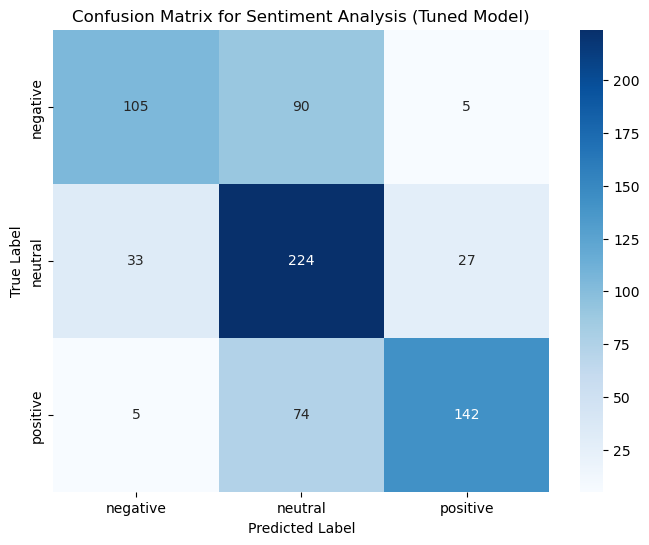


Tuned model saved to: models\logistic_regression_sentiment_model_tuned.joblib

Hyperparameter tuning and re-evaluation complete. Check the new accuracy and F1-scores!


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib # For saving the best model

print("Starting Hyperparameter Tuning for Logistic Regression...")

# Define the parameter grid to search
# 'C': Inverse of regularization strength; smaller values specify stronger regularization.
#      Regularization helps prevent overfitting.
# 'solver': Algorithm to use in the optimization problem. 'liblinear' is good for small datasets,
#           'saga' is good for larger ones and supports more regularization options.
# 'penalty': Regularization type (L1 or L2). L1 can lead to sparse solutions (feature selection).
param_grid = {
    'C': [0.1, 1.0, 10.0, 100.0], # Common range for C
    'solver': ['liblinear', 'saga'], # Popular solvers
    'penalty': ['l1', 'l2'] # L1 and L2 regularization
}

# Initialize Logistic Regression model (without specific parameters for now)
log_reg = LogisticRegression(max_iter=2000, random_state=42) # Increased max_iter for more complex solvers

# Initialize GridSearchCV
# estimator: The model to tune
# param_grid: The dictionary of parameters to search
# cv: Number of folds for cross-validation (5 is common)
# scoring: Metric to optimize (e.g., 'f1_weighted' for multi-class, or 'accuracy')
# verbose: Controls the verbosity of the output (higher means more info)
# n_jobs: Number of CPU cores to use (-1 means use all available)
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5, # 5-fold cross-validation
    scoring='f1_weighted', # Optimize for weighted F1-score (good for imbalanced classes)
    verbose=3, # Shows detailed progress
    n_jobs=-1 # Use all available CPU cores for faster execution
)

# Fit GridSearchCV to the training data
print("Performing Grid Search Cross-Validation... This might take a while.")
grid_search.fit(X_train, y_train)

print("\n--- Hyperparameter Tuning Complete ---")

# Get the best parameters and the best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation F1-score (weighted): {grid_search.best_score_:.4f}")

# Get the best model
best_model = grid_search.best_estimator_
print("\nBest model (with optimized hyperparameters) has been identified.")

# Evaluate the best model on the test set
print("\n--- Evaluating the Best Model on Test Set ---")
y_pred_best = best_model.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Overall Accuracy of Best Model: {accuracy_best:.4f}")

print("\nClassification Report (Best Model):")
target_names = ['negative', 'neutral', 'positive']
present_labels_in_y_test = np.unique(y_test)
filtered_target_names = [name for i, name in enumerate(target_names) if i in present_labels_in_y_test]
print(classification_report(y_test, y_pred_best, target_names=filtered_target_names, digits=4))

# Plotting the Confusion Matrix for the best model
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Sentiment Analysis (Tuned Model)')
plt.show()

# Save the best model and vectorizer (overwriting previous ones or saving new)
model_save_path_tuned = os.path.join('models', 'logistic_regression_sentiment_model_tuned.joblib')
joblib.dump(best_model, model_save_path_tuned)
print(f"\nTuned model saved to: {model_save_path_tuned}")

# You might want to save the vectorizer again if you also tuned its parameters,
# but for now, we'll assume the same vectorizer from previous step is fine.
# If you plan to tune TF-IDF params, you'd integrate TfidfVectorizer into the GridSearchCV pipeline.

print("\nHyperparameter tuning and re-evaluation complete. Check the new accuracy and F1-scores!")

Starting Hyperparameter Tuning for Support Vector Machine (SVM)...
Performing Grid Search Cross-Validation for SVM... This will take some time.
Fitting 5 folds for each of 4 candidates, totalling 20 fits

--- SVM Hyperparameter Tuning Complete ---
Best SVM parameters found: {'C': 1.0, 'kernel': 'linear'}
Best cross-validation F1-score (weighted) for SVM: 0.6156

Best SVM model (with optimized hyperparameters) has been identified.

--- Evaluating the Best SVM Model on Test Set ---
Overall Accuracy of Best SVM Model: 0.6369

Classification Report (Best SVM Model):
              precision    recall  f1-score   support

    negative     0.6446    0.5350    0.5847       200
     neutral     0.5637    0.7324    0.6371       284
    positive     0.7882    0.6063    0.6854       221

    accuracy                         0.6369       705
   macro avg     0.6655    0.6246    0.6357       705
weighted avg     0.6570    0.6369    0.6374       705



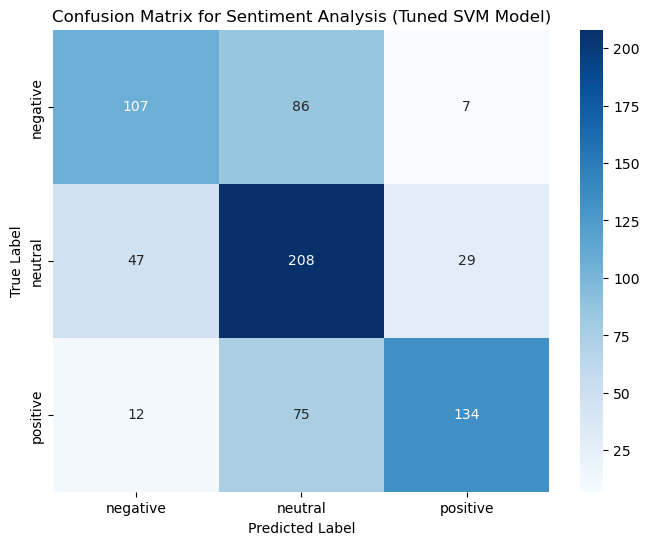


Tuned SVM model saved to: models\svm_sentiment_model_tuned.joblib

SVM model training and evaluation complete. Review the new accuracy and F1-scores!


In [21]:
from sklearn.svm import SVC # Import Support Vector Classifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib # For saving the best model

print("Starting Hyperparameter Tuning for Support Vector Machine (SVM)...")

# Initialize the SVM classifier
# We'll use a linear kernel first, as it's efficient for text data.
# For high-dimensional sparse data like TF-IDF, LinearSVC or SVC(kernel='linear') is often preferred.
# SVC(kernel='linear') is more flexible if you need probability estimates, but LinearSVC is faster.
# Let's use SVC with a linear kernel for now.
svm_model = SVC(random_state=42)

# Define the parameter grid to search for SVM
# 'C': Regularization parameter. The strength of the regularization is inversely proportional to C.
#      It controls the trade-off between achieving a low training error and a low testing error.
# 'kernel': Defines the type of hyperplane used to separate the data. 'linear' is common for text.
# 'gamma': Kernel coefficient for 'rbf', 'poly' and 'sigmoid'. Not applicable for 'linear' kernel.
param_grid_svm = {
    'C': [0.1, 1.0, 10.0, 100.0], # Common values for C
    'kernel': ['linear'] # Keep it linear for high-dimensional text data initially
}

# Initialize GridSearchCV for SVM
grid_search_svm = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid_svm,
    cv=5, # 5-fold cross-validation
    scoring='f1_weighted', # Optimize for weighted F1-score
    verbose=3, # Shows detailed progress
    n_jobs=-1 # Use all available CPU cores
)

# Fit GridSearchCV to the training data
print("Performing Grid Search Cross-Validation for SVM... This will take some time.")
grid_search_svm.fit(X_train, y_train)

print("\n--- SVM Hyperparameter Tuning Complete ---")

# Get the best parameters and the best score
print(f"Best SVM parameters found: {grid_search_svm.best_params_}")
print(f"Best cross-validation F1-score (weighted) for SVM: {grid_search_svm.best_score_:.4f}")

# Get the best SVM model
best_svm_model = grid_search_svm.best_estimator_
print("\nBest SVM model (with optimized hyperparameters) has been identified.")

# Evaluate the best SVM model on the test set
print("\n--- Evaluating the Best SVM Model on Test Set ---")
y_pred_svm = best_svm_model.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Overall Accuracy of Best SVM Model: {accuracy_svm:.4f}")

print("\nClassification Report (Best SVM Model):")
target_names = ['negative', 'neutral', 'positive']
present_labels_in_y_test = np.unique(y_test)
filtered_target_names = [name for i, name in enumerate(target_names) if i in present_labels_in_y_test]
print(classification_report(y_test, y_pred_svm, target_names=filtered_target_names, digits=4))

# Plotting the Confusion Matrix for the best SVM model
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Sentiment Analysis (Tuned SVM Model)')
plt.show()

# Save the best SVM model
model_save_path_svm = os.path.join('models', 'svm_sentiment_model_tuned.joblib')
joblib.dump(best_svm_model, model_save_path_svm)
print(f"\nTuned SVM model saved to: {model_save_path_svm}")

print("\nSVM model training and evaluation complete. Review the new accuracy and F1-scores!")

In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import os
import joblib # <--- ADD THIS LINE!

print("Starting Step 7.1: Prepare Data for Deep Learning (Tokenization & Padding)")

# Define the path to your cleaned dataset
cleaned_dataset_path = os.path.join('data', 'cleaned_social_media_comments.csv')

try:
    # Load the cleaned data
    df_cleaned = pd.read_csv(cleaned_dataset_path)
    print(f"Cleaned data loaded successfully from: {cleaned_dataset_path}")
    print(f"Shape of cleaned data: {df_cleaned.shape}")
    print("First 5 rows of cleaned data:")
    print(df_cleaned.head())

except FileNotFoundError:
    print(f"Error: The cleaned dataset file was not found at '{cleaned_dataset_path}'.")
    print("Please ensure you completed Step 2.4 and the file exists.")
except Exception as e:
    print(f"An error occurred while loading the cleaned dataset: {e}")

# Separate features (X_text) and target (y)
X_text = df_cleaned['cleaned_text'].astype(str) # Ensure text is string type
y = df_cleaned['sentiment_numerical']

print(f"\nFeatures (X_text) shape: {X_text.shape}")
print(f"Target (y) shape: {y.shape}")

# Define maximum number of words to keep, based on word frequency
MAX_NUM_WORDS = 10000

# Initialize Keras Tokenizer
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<unk>")

# Fit the tokenizer on your cleaned text data
print(f"\nFitting tokenizer on {len(X_text)} text samples...")
tokenizer.fit_on_texts(X_text)
print(f"Tokenizer fitted. Vocabulary size: {len(tokenizer.word_index)}")

# Convert text documents to sequences of integers
X_sequences = tokenizer.texts_to_sequences(X_text)
print(f"First 5 text sequences:\n{X_sequences[:5]}")

# Determine the maximum sequence length (length of the longest comment)
MAX_SEQUENCE_LENGTH = max(len(seq) for seq in X_sequences)
print(f"\nMaximum sequence length found: {MAX_SEQUENCE_LENGTH} words.")

# Pad sequences to a uniform length
X_padded = pad_sequences(X_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
print(f"Shape of padded sequences (X_padded): {X_padded.shape}")
print(f"First 5 padded sequences (truncated for display):\n{X_padded[:5, :min(20, X_padded.shape[1])]}\n...")

# --- Prepare Labels for Deep Learning ---
label_binarizer = LabelBinarizer()
y_one_hot = label_binarizer.fit_transform(y)

print(f"Original unique labels: {label_binarizer.classes_}")
print(f"Shape of one-hot encoded labels (y_one_hot): {y_one_hot.shape}")
print(f"First 5 one-hot encoded labels:\n{y_one_hot[:5]}")

# Split the padded sequences and one-hot encoded labels into training and testing sets
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_padded, y_one_hot, test_size=0.2, random_state=42, stratify=y
)

print(f"\n--- Data Preparation for Deep Learning Complete ---")
print(f"Shape of X_train_dl (training sequences): {X_train_dl.shape}")
print(f"Shape of X_test_dl (testing sequences): {X_test_dl.shape}")
print(f"Shape of y_train_dl (training one-hot labels): {y_train_dl.shape}")
print(f"Shape of y_test_dl (testing one-hot labels): {y_test_dl.shape}")

# Save the tokenizer and max_sequence_length for future use when making new predictions
tokenizer_save_path = os.path.join('models', 'dl_tokenizer.joblib')
joblib.dump(tokenizer, tokenizer_save_path)
print(f"Tokenizer saved to: {tokenizer_save_path}")

dl_params = {'max_sequence_length': MAX_SEQUENCE_LENGTH,
             'sentiment_label_map': {0: 'negative', 1: 'neutral', 2: 'positive'}}
dl_params_path = os.path.join('models', 'dl_params.joblib')
joblib.dump(dl_params, dl_params_path)
print(f"DL parameters (max_sequence_length, sentiment_label_map) saved to: {dl_params_path}")

Starting Step 7.1: Prepare Data for Deep Learning (Tokenization & Padding)
Cleaned data loaded successfully from: data\cleaned_social_media_comments.csv
Shape of cleaned data: (3522, 2)
First 5 rows of cleaned data:
                                        cleaned_text  sentiment_numerical
0                                   last session day                    1
1  shanghai also really exciting precisely skyscr...                    2
2  recession hit veronique branquinho quit compan...                    0
3                                         happy bday                    2
4                                               like                    2

Features (X_text) shape: (3522,)
Target (y) shape: (3522,)

Fitting tokenizer on 3522 text samples...
Tokenizer fitted. Vocabulary size: 6559
First 5 text sequences:
[[37, 906, 3], [2323, 172, 23, 642, 2324, 2325, 2326, 4, 643, 1486, 2327, 2328], [1487, 240, 2329, 2330, 2331, 1488, 495], [20, 644], [6]]

Maximum sequence length found: 21

In [4]:
import os # <--- ADD THIS LINE!
import numpy as np # <--- ADD THIS LINE!
import joblib # <--- ADD THIS LINE!

# No new imports needed if running in the same session and previous cell ran successfully
# This is a general comment, but it's safer to explicitly import if you're hitting NameErrors.

# Define the path to the GloVe embeddings file
GLOVE_DIR = os.path.join('data', 'glove')
GLOVE_FILE = os.path.join(GLOVE_DIR, 'glove.6B.100d.txt') # Using 100-dimensional vectors
EMBEDDING_DIM = 100 # This must match the dimension of the GloVe file you downloaded (e.g., 100d for 100 dimensions)

# Load the pre-trained GloVe word embeddings
print(f"Loading GloVe embeddings from: {GLOVE_FILE}...")
embeddings_index = {}
try:
    with open(GLOVE_FILE, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"Loaded {len(embeddings_index)} word vectors.")
except FileNotFoundError:
    print(f"Error: GloVe file not found at '{GLOVE_FILE}'.")
    print("Please ensure you downloaded 'glove.6B.zip', extracted 'glove.6B.100d.txt', and placed it in the 'data/glove/' folder.")
    exit() # Exit if the file isn't found

# Create an embedding matrix
# This matrix will contain the GloVe vector for each word in our tokenizer's vocabulary.
# Words not found in GloVe will have a vector of zeros.

# Make sure 'tokenizer' and 'MAX_NUM_WORDS' are defined from the previous cell (Step 7.1)
# If you ran this cell in a new session without running Step 7.1 first,
# you would need to load the tokenizer and MAX_NUM_WORDS from joblib.
# For now, assuming you are running sequentially.
if 'tokenizer' not in locals() or 'MAX_NUM_WORDS' not in locals():
    print("Warning: 'tokenizer' or 'MAX_NUM_WORDS' not found in current scope.")
    print("Attempting to load them from saved files...")
    try:
        tokenizer = joblib.load(os.path.join('models', 'dl_tokenizer.joblib'))
        dl_params = joblib.load(os.path.join('models', 'dl_params.joblib'))
        MAX_NUM_WORDS = dl_params['max_sequence_length'] # This assumes MAX_NUM_WORDS was saved as max_sequence_length
        # Re-evaluating MAX_NUM_WORDS based on tokenizer's num_words
        if hasattr(tokenizer, 'num_words') and tokenizer.num_words is not None:
             MAX_NUM_WORDS = tokenizer.num_words
        else: # Fallback if tokenizer doesn't have num_words or it's None
             MAX_NUM_WORDS = 10000 # Default if not explicitly found in tokenizer
        print("Tokenizer and DL parameters loaded successfully.")
    except FileNotFoundError:
        print("Fatal Error: Could not load tokenizer or DL parameters. Please ensure Step 7.1 was run and files saved.")
        exit()
    except Exception as e:
        print(f"Fatal Error loading tokenizer/params: {e}")
        exit()


word_index = tokenizer.word_index # Get the vocabulary from the tokenizer fitted in Step 7.1
num_words_in_vocab = min(MAX_NUM_WORDS, len(word_index) + 1) # +1 for 0-indexed vocabulary or potential OOV token

embedding_matrix = np.zeros((num_words_in_vocab, EMBEDDING_DIM))
words_found = 0
for word, i in word_index.items():
    if i < num_words_in_vocab: # Only include words up to our defined MAX_NUM_WORDS
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            words_found += 1

print(f"\nCreated embedding matrix of shape: {embedding_matrix.shape}")
print(f"Words from our vocabulary found in GloVe embeddings: {words_found} out of {num_words_in_vocab - 1}") # -1 for OOV token
print("This embedding matrix will be used as the weights for the Embedding layer in our neural network.")

print("\n--- Word Embedding Preparation Complete ---")
print("We now have a numerical representation (embedding matrix) for our vocabulary, ready for the neural network.")

Loading GloVe embeddings from: data\glove\glove.6B.100d.txt...
Loaded 400000 word vectors.
Attempting to load them from saved files...
Tokenizer and DL parameters loaded successfully.

Created embedding matrix of shape: (6560, 100)
Words from our vocabulary found in GloVe embeddings: 5295 out of 6559
This embedding matrix will be used as the weights for the Embedding layer in our neural network.

--- Word Embedding Preparation Complete ---
We now have a numerical representation (embedding matrix) for our vocabulary, ready for the neural network.


Starting Step 7.3: Build and Train a Simple Deep Learning Model (LSTM)
Attempting to re-prepare data and re-generate embedding matrix from saved components...
Data (X_train_dl, y_train_dl etc.) re-prepared successfully.
Loaded 400000 word vectors (re-loaded for fresh session).
Embedding matrix re-generated successfully for fresh session.

Building the LSTM Neural Network model...


C:\Users\pkv23\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       656,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 656,000 (2.50 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 656,000 (2.50 MB)


Training the Deep Learning model... This will take a while.
Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3947 - loss: 1.0902 - val_accuracy: 0.5213 - val_loss: 1.0390
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4880 - loss: 1.0261 - val_accuracy: 0.6525 - val_loss: 0.8132
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5748 - loss: 0.9274 - val_accuracy: 0.6454 - val_loss: 0.8198
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5883 - loss: 0.8798 - val_accuracy: 0.6667 - val_loss: 0.8264
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6142 - loss: 0.8637 - val_accuracy: 0.6738 - val_loss: 0.7925
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6231 - loss: 0.8344 - val_accuracy: 0.7163 - val_loss: 0.7678
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6327 - loss: 0.8062 - val_accuracy: 0.6950 - val_loss: 0.7724
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accu

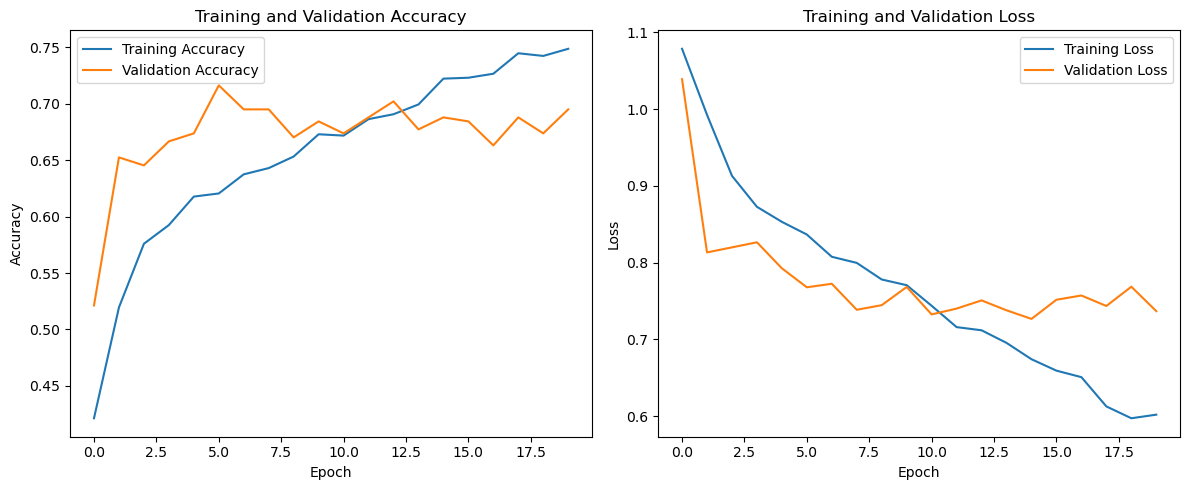


Deep Learning model built, compiled, trained, and saved.


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import joblib
import pandas as pd # <-- NEW: Added for data loading
import numpy as np # <-- NEW: Added for numpy operations
from tensorflow.keras.preprocessing.text import Tokenizer # <-- NEW: Added for data prep
from tensorflow.keras.preprocessing.sequence import pad_sequences # <-- NEW: Added for data prep
from sklearn.model_selection import train_test_split # <-- NEW: Added for data prep
from sklearn.preprocessing import LabelBinarizer # <-- NEW: Added for data prep


print("Starting Step 7.3: Build and Train a Simple Deep Learning Model (LSTM)")

# --- Ensure all necessary parameters and data are loaded/generated ---
# This block makes the cell robust against kernel restarts

# Define paths
cleaned_dataset_path = os.path.join('data', 'cleaned_social_media_comments.csv')
tokenizer_save_path = os.path.join('models', 'dl_tokenizer.joblib')
dl_params_path = os.path.join('models', 'dl_params.joblib')
GLOVE_DIR = os.path.join('data', 'glove')
GLOVE_FILE = os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')
EMBEDDING_DIM = 100 # Ensure this matches your downloaded GloVe file

# Check if essential variables for model training are defined. If not, re-prepare them.
if 'X_train_dl' not in locals() or 'y_train_dl' not in locals() or 'embedding_matrix' not in locals():
    print("Warning: Essential DL training data (X_train_dl, y_train_dl) or embedding_matrix not found in current scope.")
    print("Attempting to re-prepare data and re-generate embedding matrix from saved components...")

    try:
        # 1. Load cleaned data
        df_cleaned = pd.read_csv(cleaned_dataset_path)
        X_text = df_cleaned['cleaned_text'].astype(str)
        y = df_cleaned['sentiment_numerical']

        # 2. Load Tokenizer and DL params
        tokenizer = joblib.load(tokenizer_save_path)
        dl_params = joblib.load(dl_params_path)
        MAX_SEQUENCE_LENGTH = dl_params['max_sequence_length']
        sentiment_label_map = dl_params['sentiment_label_map'] # Needed later for prediction

        # Re-derive MAX_NUM_WORDS from tokenizer if available
        if hasattr(tokenizer, 'num_words') and tokenizer.num_words is not None:
             MAX_NUM_WORDS = tokenizer.num_words
        else: # Fallback
             MAX_NUM_WORDS = 10000

        # 3. Re-tokenize and re-pad text
        X_sequences = tokenizer.texts_to_sequences(X_text)
        X_padded = pad_sequences(X_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

        # 4. Re-one-hot encode labels
        label_binarizer = LabelBinarizer()
        y_one_hot = label_binarizer.fit_transform(y)

        # 5. Re-split data
        X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
            X_padded, y_one_hot, test_size=0.2, random_state=42, stratify=y
        )
        print("Data (X_train_dl, y_train_dl etc.) re-prepared successfully.")

        # 6. Re-generate embedding matrix (from GloVe file)
        embeddings_index = {}
        with open(GLOVE_FILE, encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
        print(f"Loaded {len(embeddings_index)} word vectors (re-loaded for fresh session).")

        word_index = tokenizer.word_index
        num_words_in_vocab = min(MAX_NUM_WORDS, len(word_index) + 1)
        embedding_matrix = np.zeros((num_words_in_vocab, EMBEDDING_DIM))
        for word, i in word_index.items():
            if i < num_words_in_vocab:
                embedding_vector = embeddings_index.get(word)
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
        print("Embedding matrix re-generated successfully for fresh session.")

    except FileNotFoundError as fnfe:
        print(f"Fatal Error: A required file was not found: {fnfe}. Please ensure previous steps were run and files exist.")
        exit() # Exit if crucial files are missing
    except Exception as e:
        print(f"Fatal Error during data re-preparation or embedding loading: {e}")
        exit() # Exit for other critical errors
else:
    print("Essential DL parameters and training data found in current scope. Proceeding directly to model building.")


# Define the number of sentiment classes
NUM_CLASSES = y_train_dl.shape[1] # This will be 3 for negative, neutral, positive

# --- Build the Keras Model ---
print("\nBuilding the LSTM Neural Network model...")
model = Sequential()

# Embedding Layer: Maps word IDs to GloVe word vectors
model.add(Embedding(
    input_dim=num_words_in_vocab, # Vocabulary size
    output_dim=EMBEDDING_DIM,    # Dimension of the word vectors (e.g., 100)
    weights=[embedding_matrix],  # Initialize with pre-trained GloVe embeddings
    input_length=MAX_SEQUENCE_LENGTH, # Length of input sequences
    trainable=False              # Keep embeddings fixed (not updated during training)
))

# LSTM Layer: Processes the sequence of embeddings
model.add(LSTM(
    units=128,                   # Number of LSTM units (a common choice)
    dropout=0.2,                 # Dropout for regularization (reduces overfitting)
    recurrent_dropout=0.2        # Dropout for recurrent connections
))

# Dense (Hidden) Layer: Standard neural network layer
model.add(Dense(
    units=64,                    # Number of neurons in the hidden layer
    activation='relu'            # ReLU activation function
))
model.add(Dropout(0.2)) # Another dropout layer to prevent overfitting

# Output Layer:
model.add(Dense(
    units=NUM_CLASSES,           # 3 classes (negative, neutral, positive)
    activation='softmax'         # Softmax for multi-class probability output
))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

# --- Train the Model ---
print("\nTraining the Deep Learning model... This will take a while.")

# Callbacks:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=os.path.join('models', 'best_dl_sentiment_model.keras'), monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train_dl,
    y_train_dl,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

print("\n--- Deep Learning Model Training Complete ---")
print(f"Best model weights saved to: {os.path.join('models', 'best_dl_sentiment_model.keras')}")

# You can optionally plot training history
import matplotlib.pyplot as plt # Moved import here as it's only used for plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

print("\nDeep Learning model built, compiled, trained, and saved.")

Starting Step 7.4: Evaluate the Deep Learning Model
Test data (X_test_dl, y_test_dl) and sentiment_label_map found in current scope. Proceeding to evaluation.
Deep Learning model loaded successfully from: models\best_dl_sentiment_model.keras

--- Evaluating the Best Deep Learning Model on Test Set ---
Overall Accuracy of Deep Learning Model on Test Set: 0.6809
Overall Loss of Deep Learning Model on Test Set: 0.7767

Classification Report (Deep Learning Model):
              precision    recall  f1-score   support

    negative     0.7643    0.5350    0.6294       200
     neutral     0.6093    0.7852    0.6862       284
    positive     0.7538    0.6787    0.7143       221

    accuracy                         0.6809       705
   macro avg     0.7091    0.6663    0.6766       705
weighted avg     0.6986    0.6809    0.6789       705



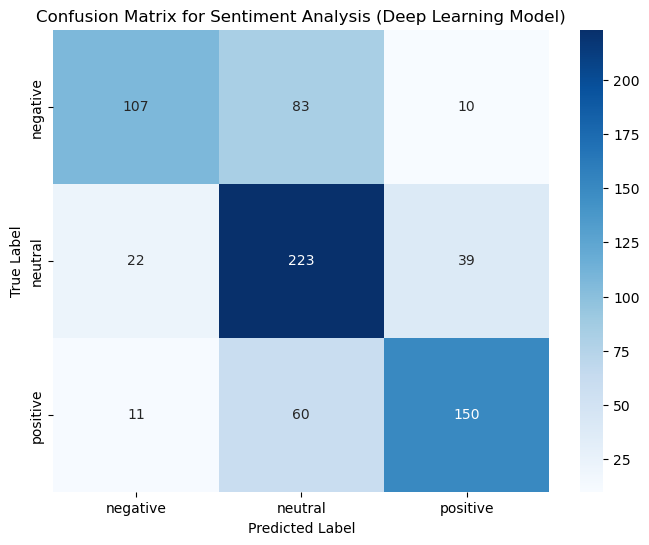


Deep Learning model evaluation complete. Review the metrics to understand performance.


In [10]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import joblib # For loading dl_params and tokenizer

print("Starting Step 7.4: Evaluate the Deep Learning Model")

# --- Load necessary parameters and test data if not in current scope ---
if 'X_test_dl' not in locals() or 'y_test_dl' not in locals() or 'sentiment_label_map' not in locals():
    print("Warning: X_test_dl, y_test_dl or sentiment_label_map not found in current scope.")
    print("Attempting to re-load data and parameters for evaluation...")
    try:
        # Define paths (ensure these match your actual file locations)
        cleaned_dataset_path = os.path.join('data', 'cleaned_social_media_comments.csv')
        tokenizer_save_path = os.path.join('models', 'dl_tokenizer.joblib')
        dl_params_path = os.path.join('models', 'dl_params.joblib')

        # Load data
        df_cleaned = pd.read_csv(cleaned_dataset_path)
        X_text = df_cleaned['cleaned_text'].astype(str)
        y = df_cleaned['sentiment_numerical']

        # Load tokenizer and DL params
        tokenizer = joblib.load(tokenizer_save_path)
        dl_params = joblib.load(dl_params_path)
        MAX_SEQUENCE_LENGTH = dl_params['max_sequence_length']
        sentiment_label_map = dl_params['sentiment_label_map']

        # Re-tokenize and re-pad text
        X_sequences = tokenizer.texts_to_sequences(X_text)
        X_padded = pad_sequences(X_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

        # Re-one-hot encode labels
        label_binarizer = LabelBinarizer()
        y_one_hot = label_binarizer.fit_transform(y)

        # Re-split data to get X_test_dl and y_test_dl
        _, X_test_dl, _, y_test_dl = train_test_split(
            X_padded, y_one_hot, test_size=0.2, random_state=42, stratify=y
        )
        print("Test data (X_test_dl, y_test_dl) and sentiment_label_map re-loaded successfully.")
    except FileNotFoundError as fnfe:
        print(f"Fatal Error: A required file was not found for evaluation: {fnfe}. Please ensure all previous steps were run and files exist.")
        exit()
    except Exception as e:
        print(f"Fatal Error during re-loading data for evaluation: {e}")
        exit()
else:
    print("Test data (X_test_dl, y_test_dl) and sentiment_label_map found in current scope. Proceeding to evaluation.")


# Load the best trained model
model_load_path = os.path.join('models', 'best_dl_sentiment_model.keras')
try:
    best_dl_model = load_model(model_load_path)
    print(f"Deep Learning model loaded successfully from: {model_load_path}")
except Exception as e:
    print(f"Error: Could not load the saved model from {model_load_path}. Please ensure the model was saved correctly in Step 7.3.")
    print(f"Error details: {e}")
    exit()

print("\n--- Evaluating the Best Deep Learning Model on Test Set ---")

# Evaluate the model on the test set
loss, accuracy = best_dl_model.evaluate(X_test_dl, y_test_dl, verbose=0)
print(f"Overall Accuracy of Deep Learning Model on Test Set: {accuracy:.4f}")
print(f"Overall Loss of Deep Learning Model on Test Set: {loss:.4f}")

# Make predictions
y_pred_proba = best_dl_model.predict(X_test_dl, verbose=0)
y_pred_dl = np.argmax(y_pred_proba, axis=1) # Convert probabilities to class labels (0, 1, 2)
y_true_dl = np.argmax(y_test_dl, axis=1) # Convert one-hot encoded true labels back to class labels

print("\nClassification Report (Deep Learning Model):")
# Map numerical labels to string names for the classification report
target_names_list = [sentiment_label_map[i] for i in sorted(sentiment_label_map.keys())]
# Filter target_names to only include labels present in y_true_dl and y_pred_dl
unique_labels_true = np.unique(y_true_dl)
unique_labels_pred = np.unique(y_pred_dl)
all_unique_labels = sorted(np.unique(np.concatenate((unique_labels_true, unique_labels_pred))))
filtered_target_names = [target_names_list[i] for i in all_unique_labels]


print(classification_report(y_true_dl, y_pred_dl, target_names=filtered_target_names, digits=4))

# Plotting the Confusion Matrix
cm_dl = confusion_matrix(y_true_dl, y_pred_dl)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dl, annot=True, fmt='d', cmap='Blues', xticklabels=filtered_target_names, yticklabels=filtered_target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Sentiment Analysis (Deep Learning Model)')
plt.show()

print("\nDeep Learning model evaluation complete. Review the metrics to understand performance.")

Starting Step 7.5: Build and Train a Bidirectional LSTM Model
Essential DL parameters and training data found in current scope. Proceeding directly to model building.

Building the Bidirectional LSTM Neural Network model...


C:\Users\pkv23\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │       656,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 656,000 (2.50 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 656,000 (2.50 MB)


Training the Bidirectional LSTM model... This will take a while.
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.3998 - loss: 1.0793 - val_accuracy: 0.5993 - val_loss: 0.9416
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5351 - loss: 0.9605 - val_accuracy: 0.6241 - val_loss: 0.8379
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5679 - loss: 0.8882 - val_accuracy: 0.6809 - val_loss: 0.8025
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6061 - loss: 0.8609 - val_accuracy: 0.6702 - val_loss: 0.8081
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6152 - loss: 0.8504 - val_accuracy: 0.6844 - val_loss: 0.7903
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6289 - loss: 0.8207 - val_accuracy: 0.6525 - val_loss: 0.8186
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6293 - loss: 0.7986 - val_accuracy: 0.6631 - val_loss: 0.7729
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms

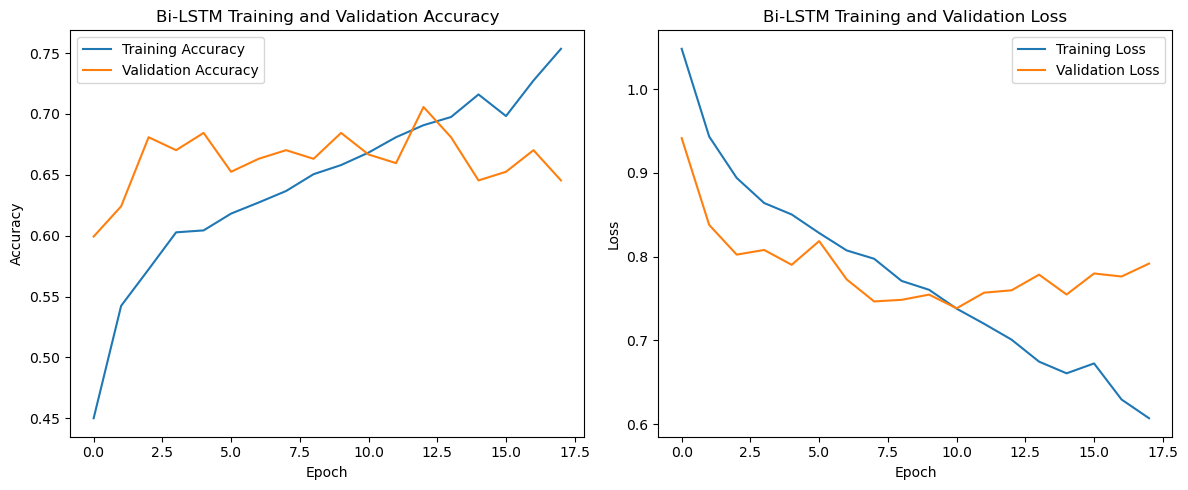


Bidirectional LSTM model built, compiled, trained, and saved.


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import joblib
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt


print("Starting Step 7.5: Build and Train a Bidirectional LSTM Model")

# --- Ensure all necessary parameters and data are loaded/generated ---
# This block makes the cell robust against kernel restarts

# Define paths
cleaned_dataset_path = os.path.join('data', 'cleaned_social_media_comments.csv')
tokenizer_save_path = os.path.join('models', 'dl_tokenizer.joblib')
dl_params_path = os.path.join('models', 'dl_params.joblib')
GLOVE_DIR = os.path.join('data', 'glove')
GLOVE_FILE = os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')
EMBEDDING_DIM = 100 # Ensure this matches your downloaded GloVe file

# Check if essential variables for model training are defined. If not, re-prepare them.
if 'X_train_dl' not in locals() or 'y_train_dl' not in locals() or 'embedding_matrix' not in locals():
    print("Warning: Essential DL training data (X_train_dl, y_train_dl) or embedding_matrix not found in current scope.")
    print("Attempting to re-prepare data and re-generate embedding matrix from saved components...")

    try:
        # 1. Load cleaned data
        df_cleaned = pd.read_csv(cleaned_dataset_path)
        X_text = df_cleaned['cleaned_text'].astype(str)
        y = df_cleaned['sentiment_numerical']

        # 2. Load Tokenizer and DL params
        tokenizer = joblib.load(tokenizer_save_path)
        dl_params = joblib.load(dl_params_path)
        MAX_SEQUENCE_LENGTH = dl_params['max_sequence_length']
        sentiment_label_map = dl_params['sentiment_label_map'] # Needed later for prediction

        # Re-derive MAX_NUM_WORDS from tokenizer if available
        if hasattr(tokenizer, 'num_words') and tokenizer.num_words is not None:
             MAX_NUM_WORDS = tokenizer.num_words
        else: # Fallback
             MAX_NUM_WORDS = 10000

        # 3. Re-tokenize and re-pad text
        X_sequences = tokenizer.texts_to_sequences(X_text)
        X_padded = pad_sequences(X_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

        # 4. Re-one-hot encode labels
        label_binarizer = LabelBinarizer()
        y_one_hot = label_binarizer.fit_transform(y)

        # 5. Re-split data
        X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
            X_padded, y_one_hot, test_size=0.2, random_state=42, stratify=y
        )
        print("Data (X_train_dl, y_train_dl etc.) re-prepared successfully.")

        # 6. Re-generate embedding matrix (from GloVe file)
        embeddings_index = {}
        with open(GLOVE_FILE, encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
        print(f"Loaded {len(embeddings_index)} word vectors (re-loaded for fresh session).")

        word_index = tokenizer.word_index
        num_words_in_vocab = min(MAX_NUM_WORDS, len(word_index) + 1)
        embedding_matrix = np.zeros((num_words_in_vocab, EMBEDDING_DIM))
        for word, i in word_index.items():
            if i < num_words_in_vocab:
                embedding_vector = embeddings_index.get(word)
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
        print("Embedding matrix re-generated successfully for fresh session.")

    except FileNotFoundError as fnfe:
        print(f"Fatal Error: A required file was not found: {fnfe}. Please ensure previous steps were run and files exist.")
        exit()
    except Exception as e:
        print(f"Fatal Error during data re-preparation or embedding loading: {e}")
        exit()
else:
    print("Essential DL parameters and training data found in current scope. Proceeding directly to model building.")


# Define the number of sentiment classes
NUM_CLASSES = y_train_dl.shape[1] # This will be 3 for negative, neutral, positive

# --- Build the Keras Bidirectional LSTM Model ---
print("\nBuilding the Bidirectional LSTM Neural Network model...")
model_bi = Sequential()

# Embedding Layer: Maps word IDs to GloVe word vectors
model_bi.add(Embedding(
    input_dim=num_words_in_vocab,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
))

# Bidirectional LSTM Layer
model_bi.add(Bidirectional(LSTM(
    units=128,                   # Number of LSTM units for each direction
    dropout=0.3,                 # Increased dropout slightly
    recurrent_dropout=0.3        # Increased recurrent dropout slightly
)))

# Dense (Hidden) Layer
model_bi.add(Dense(
    units=64,
    activation='relu'
))
model_bi.add(Dropout(0.3)) # Increased dropout slightly

# Output Layer
model_bi.add(Dense(
    units=NUM_CLASSES,
    activation='softmax'
))

# Compile the model
model_bi.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model_bi.summary()

# --- Train the Model ---
print("\nTraining the Bidirectional LSTM model... This will take a while.")

# Callbacks:
callbacks_bi = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True), # Increased patience
    ModelCheckpoint(filepath=os.path.join('models', 'best_bi_lstm_sentiment_model.keras'), monitor='val_loss', save_best_only=True)
]

history_bi = model_bi.fit(
    X_train_dl,
    y_train_dl,
    epochs=50,                  # Maximum number of epochs to train
    batch_size=64,              # Increased batch size for potentially faster training
    validation_split=0.1,       # Use 10% of training data for validation
    callbacks=callbacks_bi,
    verbose=1
)

print("\n--- Bidirectional LSTM Model Training Complete ---")
print(f"Best model weights saved to: {os.path.join('models', 'best_bi_lstm_sentiment_model.keras')}")

# Plotting training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_bi.history['accuracy'], label='Training Accuracy')
plt.plot(history_bi.history['val_accuracy'], label='Validation Accuracy')
plt.title('Bi-LSTM Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_bi.history['loss'], label='Training Loss')
plt.plot(history_bi.history['val_loss'], label='Validation Loss')
plt.title('Bi-LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

print("\nBidirectional LSTM model built, compiled, trained, and saved.")

Starting Step 7.6: Evaluate the Bidirectional LSTM Model
Test data (X_test_dl, y_test_dl) and sentiment_label_map found in current scope. Proceeding to evaluation.
Bidirectional LSTM model loaded successfully from: models\best_bi_lstm_sentiment_model.keras

--- Evaluating the Best Bidirectional LSTM Model on Test Set ---
Overall Accuracy of Bidirectional LSTM Model on Test Set: 0.6610
Overall Loss of Bidirectional LSTM Model on Test Set: 0.7838

Classification Report (Bidirectional LSTM Model):
              precision    recall  f1-score   support

    negative     0.7233    0.5750    0.6407       200
     neutral     0.6024    0.7148    0.6538       284
    positive     0.7081    0.6697    0.6884       221

    accuracy                         0.6610       705
   macro avg     0.6779    0.6532    0.6609       705
weighted avg     0.6698    0.6610    0.6609       705



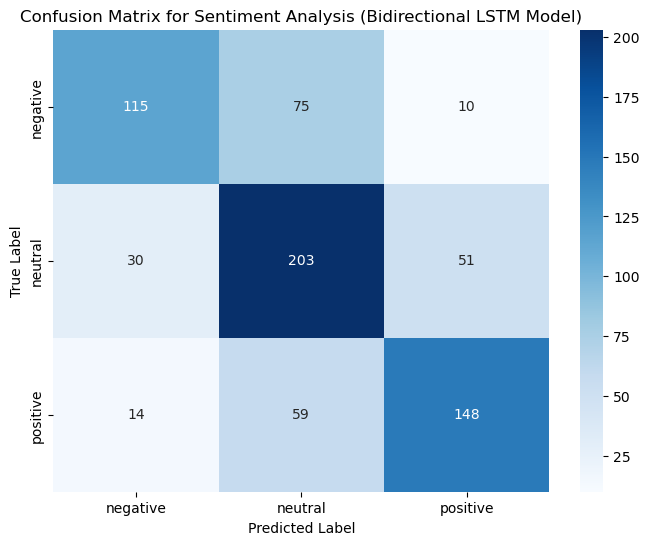


Bidirectional LSTM model evaluation complete. Review the metrics to understand performance.


In [14]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import joblib
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer


print("Starting Step 7.6: Evaluate the Bidirectional LSTM Model")

# --- Load necessary parameters and test data if not in current scope ---
if 'X_test_dl' not in locals() or 'y_test_dl' not in locals() or 'sentiment_label_map' not in locals():
    print("Warning: X_test_dl, y_test_dl or sentiment_label_map not found in current scope.")
    print("Attempting to re-load data and parameters for evaluation...")
    try:
        # Define paths
        cleaned_dataset_path = os.path.join('data', 'cleaned_social_media_comments.csv')
        tokenizer_save_path = os.path.join('models', 'dl_tokenizer.joblib')
        dl_params_path = os.path.join('models', 'dl_params.joblib')

        # Load data
        df_cleaned = pd.read_csv(cleaned_dataset_path)
        X_text = df_cleaned['cleaned_text'].astype(str)
        y = df_cleaned['sentiment_numerical']

        # Load tokenizer and DL params
        tokenizer = joblib.load(tokenizer_save_path)
        dl_params = joblib.load(dl_params_path)
        MAX_SEQUENCE_LENGTH = dl_params['max_sequence_length']
        sentiment_label_map = dl_params['sentiment_label_map']

        # Re-tokenize and re-pad text
        X_sequences = tokenizer.texts_to_sequences(X_text)
        X_padded = pad_sequences(X_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

        # Re-one-hot encode labels
        label_binarizer = LabelBinarizer()
        y_one_hot = label_binarizer.fit_transform(y)

        # Re-split data to get X_test_dl and y_test_dl
        _, X_test_dl, _, y_test_dl = train_test_split(
            X_padded, y_one_hot, test_size=0.2, random_state=42, stratify=y
        )
        print("Test data (X_test_dl, y_test_dl) and sentiment_label_map re-loaded successfully.")
    except FileNotFoundError as fnfe:
        print(f"Fatal Error: A required file was not found for evaluation: {fnfe}. Please ensure all previous steps were run and files exist.")
        exit()
    except Exception as e:
        print(f"Fatal Error during re-loading data for evaluation: {e}")
        exit()
else:
    print("Test data (X_test_dl, y_test_dl) and sentiment_label_map found in current scope. Proceeding to evaluation.")


# Load the best trained Bidirectional LSTM model
model_load_path_bi = os.path.join('models', 'best_bi_lstm_sentiment_model.keras')
try:
    best_bi_lstm_model = load_model(model_load_path_bi)
    print(f"Bidirectional LSTM model loaded successfully from: {model_load_path_bi}")
except Exception as e:
    print(f"Error: Could not load the saved Bidirectional LSTM model from {model_load_path_bi}. Please ensure the model was saved correctly in Step 7.5.")
    print(f"Error details: {e}")
    exit()

print("\n--- Evaluating the Best Bidirectional LSTM Model on Test Set ---")

# Evaluate the model on the test set
loss_bi, accuracy_bi = best_bi_lstm_model.evaluate(X_test_dl, y_test_dl, verbose=0)
print(f"Overall Accuracy of Bidirectional LSTM Model on Test Set: {accuracy_bi:.4f}")
print(f"Overall Loss of Bidirectional LSTM Model on Test Set: {loss_bi:.4f}")

# Make predictions
y_pred_proba_bi = best_bi_lstm_model.predict(X_test_dl, verbose=0)
y_pred_bi = np.argmax(y_pred_proba_bi, axis=1) # Convert probabilities to class labels (0, 1, 2)
y_true_bi = np.argmax(y_test_dl, axis=1) # Convert one-hot encoded true labels back to class labels

print("\nClassification Report (Bidirectional LSTM Model):")
# Map numerical labels to string names for the classification report
target_names_list = [sentiment_label_map[i] for i in sorted(sentiment_label_map.keys())]
unique_labels_true = np.unique(y_true_bi)
unique_labels_pred = np.unique(y_pred_bi)
all_unique_labels = sorted(np.unique(np.concatenate((unique_labels_true, unique_labels_pred))))
filtered_target_names = [target_names_list[i] for i in all_unique_labels]

print(classification_report(y_true_bi, y_pred_bi, target_names=filtered_target_names, digits=4))

# Plotting the Confusion Matrix
cm_bi = confusion_matrix(y_true_bi, y_pred_bi)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bi, annot=True, fmt='d', cmap='Blues', xticklabels=filtered_target_names, yticklabels=filtered_target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Sentiment Analysis (Bidirectional LSTM Model)')
plt.show()

print("\nBidirectional LSTM model evaluation complete. Review the metrics to understand performance.")

Starting Step 7.7: Build and Train a CNN-LSTM Model
Essential DL parameters and training data found in current scope. Proceeding directly to model building.

Building the CNN-LSTM Neural Network model...


C:\Users\pkv23\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │       656,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 656,000 (2.50 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 656,000 (2.50 MB)


Training the CNN-LSTM model... This will take a while.
Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.3994 - loss: 1.0987 - val_accuracy: 0.5355 - val_loss: 1.0208
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5226 - loss: 0.9859 - val_accuracy: 0.6454 - val_loss: 0.8235
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6538 - loss: 0.7848 - val_accuracy: 0.6667 - val_loss: 0.7926
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7329 - loss: 0.6514 - val_accuracy: 0.6809 - val_loss: 0.8062
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7883 - loss: 0.5142 - val_accuracy: 0.6241 - val_loss: 0.9185
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8267 - loss: 0.4306 - val_accuracy: 0.6454 - val_loss: 1.0628
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8880 - loss: 0.3118 - val_accuracy: 0.6277 - val_loss: 1.1713
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy:

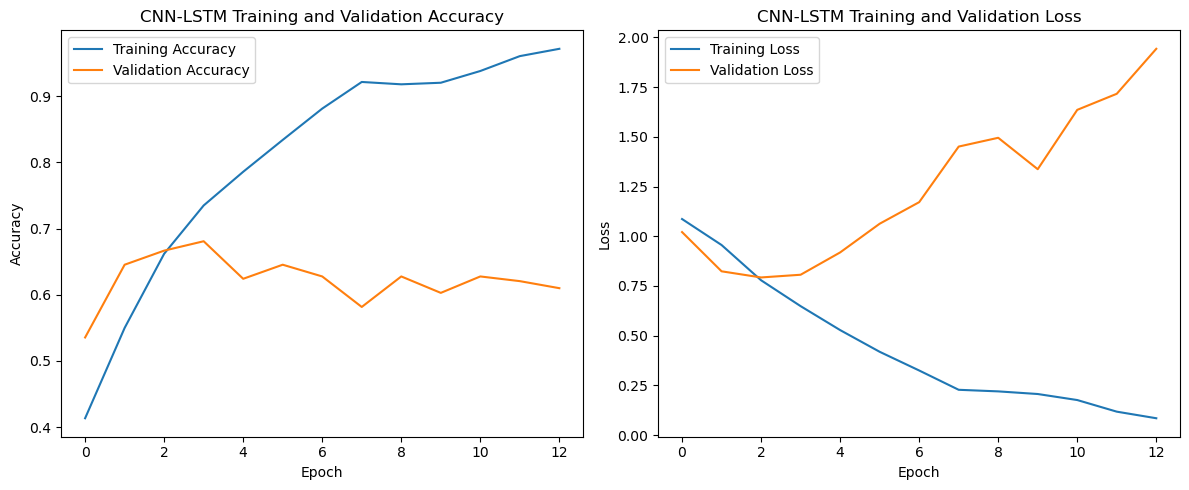


CNN-LSTM model built, compiled, trained, and saved.


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import joblib
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt


print("Starting Step 7.7: Build and Train a CNN-LSTM Model")

# --- Ensure all necessary parameters and data are loaded/generated ---
# This block makes the cell robust against kernel restarts

# Define paths
cleaned_dataset_path = os.path.join('data', 'cleaned_social_media_comments.csv')
tokenizer_save_path = os.path.join('models', 'dl_tokenizer.joblib')
dl_params_path = os.path.join('models', 'dl_params.joblib')
GLOVE_DIR = os.path.join('data', 'glove')
GLOVE_FILE = os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')
EMBEDDING_DIM = 100 # Ensure this matches your downloaded GloVe file

# Check if essential variables for model training are defined. If not, re-prepare them.
if 'X_train_dl' not in locals() or 'y_train_dl' not in locals() or 'embedding_matrix' not in locals():
    print("Warning: Essential DL training data (X_train_dl, y_train_dl) or embedding_matrix not found in current scope.")
    print("Attempting to re-prepare data and re-generate embedding matrix from saved components...")

    try:
        # 1. Load cleaned data
        df_cleaned = pd.read_csv(cleaned_dataset_path)
        X_text = df_cleaned['cleaned_text'].astype(str)
        y = df_cleaned['sentiment_numerical']

        # 2. Load Tokenizer and DL params
        tokenizer = joblib.load(tokenizer_save_path)
        dl_params = joblib.load(dl_params_path)
        MAX_SEQUENCE_LENGTH = dl_params['max_sequence_length']
        sentiment_label_map = dl_params['sentiment_label_map']

        # Re-derive MAX_NUM_WORDS from tokenizer if available
        if hasattr(tokenizer, 'num_words') and tokenizer.num_words is not None:
             MAX_NUM_WORDS = tokenizer.num_words
        else: # Fallback
             MAX_NUM_WORDS = 10000

        # 3. Re-tokenize and re-pad text
        X_sequences = tokenizer.texts_to_sequences(X_text)
        X_padded = pad_sequences(X_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

        # 4. Re-one-hot encode labels
        label_binarizer = LabelBinarizer()
        y_one_hot = label_binarizer.fit_transform(y)

        # 5. Re-split data
        X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
            X_padded, y_one_hot, test_size=0.2, random_state=42, stratify=y
        )
        print("Data (X_train_dl, y_train_dl etc.) re-prepared successfully.")

        # 6. Re-generate embedding matrix (from GloVe file)
        embeddings_index = {}
        with open(GLOVE_FILE, encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
        print(f"Loaded {len(embeddings_index)} word vectors (re-loaded for fresh session).")

        word_index = tokenizer.word_index
        num_words_in_vocab = min(MAX_NUM_WORDS, len(word_index) + 1)
        embedding_matrix = np.zeros((num_words_in_vocab, EMBEDDING_DIM))
        for word, i in word_index.items():
            if i < num_words_in_vocab:
                embedding_vector = embeddings_index.get(word)
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
        print("Embedding matrix re-generated successfully for fresh session.")

    except FileNotFoundError as fnfe:
        print(f"Fatal Error: A required file was not found: {fnfe}. Please ensure previous steps were run and files exist.")
        exit()
    except Exception as e:
        print(f"Fatal Error during data re-preparation or embedding loading: {e}")
        exit()
else:
    print("Essential DL parameters and training data found in current scope. Proceeding directly to model building.")


# Define the number of sentiment classes
NUM_CLASSES = y_train_dl.shape[1] # This will be 3 for negative, neutral, positive

# --- Build the Keras CNN-LSTM Model ---
print("\nBuilding the CNN-LSTM Neural Network model...")
model_cnn_lstm = Sequential()

# Embedding Layer
model_cnn_lstm.add(Embedding(
    input_dim=num_words_in_vocab,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
))

# 1D Convolutional Layer
model_cnn_lstm.add(Conv1D(
    filters=128,              # Number of filters (feature detectors)
    kernel_size=5,            # Size of the convolution window (e.g., look at 5 words at a time)
    activation='relu'
))
model_cnn_lstm.add(MaxPooling1D(
    pool_size=MAX_SEQUENCE_LENGTH // 4 # Max pooling over a quarter of the sequence length
))
# You can also try: MaxPooling1D(pool_size=2) for smaller pooling

# Bidirectional LSTM Layer
model_cnn_lstm.add(Bidirectional(LSTM(
    units=128,
    dropout=0.4,                 # Increased dropout for regularization
    recurrent_dropout=0.4        # Increased recurrent dropout
)))

# Dense (Hidden) Layer
model_cnn_lstm.add(Dense(
    units=64,
    activation='relu'
))
model_cnn_lstm.add(Dropout(0.4)) # Increased dropout

# Output Layer
model_cnn_lstm.add(Dense(
    units=NUM_CLASSES,
    activation='softmax'
))

# Compile the model
model_cnn_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model_cnn_lstm.summary()

# --- Train the Model ---
print("\nTraining the CNN-LSTM model... This will take a while.")

# Callbacks:
callbacks_cnn_lstm = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), # Increased patience further
    ModelCheckpoint(filepath=os.path.join('models', 'best_cnn_lstm_sentiment_model.keras'), monitor='val_loss', save_best_only=True)
]

history_cnn_lstm = model_cnn_lstm.fit(
    X_train_dl,
    y_train_dl,
    epochs=50,
    batch_size=32,              # Changed batch size back to 32 to see if it helps
    validation_split=0.1,
    callbacks=callbacks_cnn_lstm,
    verbose=1
)

print("\n--- CNN-LSTM Model Training Complete ---")
print(f"Best model weights saved to: {os.path.join('models', 'best_cnn_lstm_sentiment_model.keras')}")

# Plotting training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN-LSTM Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_lstm.history['loss'], label='Training Loss')
plt.plot(history_cnn_lstm.history['val_loss'], label='Validation Loss')
plt.title('CNN-LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

print("\nCNN-LSTM model built, compiled, trained, and saved.")

Starting Step 7.8: Evaluate the CNN-LSTM Model
Test data (X_test_dl, y_test_dl) and sentiment_label_map found in current scope. Proceeding to evaluation.
CNN-LSTM model loaded successfully from: models\best_cnn_lstm_sentiment_model.keras

--- Evaluating the Best CNN-LSTM Model on Test Set ---
Overall Accuracy of CNN-LSTM Model on Test Set: 0.6312
Overall Loss of CNN-LSTM Model on Test Set: 0.8129

Classification Report (CNN-LSTM Model):
              precision    recall  f1-score   support

    negative     0.5837    0.7150    0.6427       200
     neutral     0.6172    0.5563    0.5852       284
    positive     0.7059    0.6516    0.6776       221

    accuracy                         0.6312       705
   macro avg     0.6356    0.6410    0.6352       705
weighted avg     0.6355    0.6312    0.6305       705



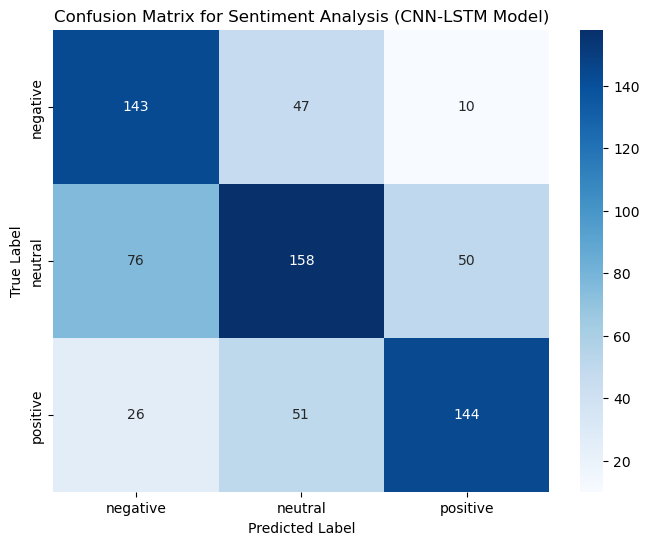


CNN-LSTM model evaluation complete. Review the metrics to understand performance.


In [18]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import joblib
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer


print("Starting Step 7.8: Evaluate the CNN-LSTM Model")

# --- Load necessary parameters and test data if not in current scope ---
if 'X_test_dl' not in locals() or 'y_test_dl' not in locals() or 'sentiment_label_map' not in locals():
    print("Warning: X_test_dl, y_test_dl or sentiment_label_map not found in current scope.")
    print("Attempting to re-load data and parameters for evaluation...")
    try:
        # Define paths
        cleaned_dataset_path = os.path.join('data', 'cleaned_social_media_comments.csv')
        tokenizer_save_path = os.path.join('models', 'dl_tokenizer.joblib')
        dl_params_path = os.path.join('models', 'dl_params.joblib')

        # Load data
        df_cleaned = pd.read_csv(cleaned_dataset_path)
        X_text = df_cleaned['cleaned_text'].astype(str)
        y = df_cleaned['sentiment_numerical']

        # Load tokenizer and DL params
        tokenizer = joblib.load(tokenizer_save_path)
        dl_params = joblib.load(dl_params_path)
        MAX_SEQUENCE_LENGTH = dl_params['max_sequence_length']
        sentiment_label_map = dl_params['sentiment_label_map']

        # Re-tokenize and re-pad text
        X_sequences = tokenizer.texts_to_sequences(X_text)
        X_padded = pad_sequences(X_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

        # Re-one-hot encode labels
        label_binarizer = LabelBinarizer()
        y_one_hot = label_binarizer.fit_transform(y)

        # Re-split data to get X_test_dl and y_test_dl
        _, X_test_dl, _, y_test_dl = train_test_split(
            X_padded, y_one_hot, test_size=0.2, random_state=42, stratify=y
        )
        print("Test data (X_test_dl, y_test_dl) and sentiment_label_map re-loaded successfully.")
    except FileNotFoundError as fnfe:
        print(f"Fatal Error: A required file was not found for evaluation: {fnfe}. Please ensure all previous steps were run and files exist.")
        exit()
    except Exception as e:
        print(f"Fatal Error during re-loading data for evaluation: {e}")
        exit()
else:
    print("Test data (X_test_dl, y_test_dl) and sentiment_label_map found in current scope. Proceeding to evaluation.")


# Load the best trained CNN-LSTM model
model_load_path_cnn_lstm = os.path.join('models', 'best_cnn_lstm_sentiment_model.keras')
try:
    best_cnn_lstm_model = load_model(model_load_path_cnn_lstm)
    print(f"CNN-LSTM model loaded successfully from: {model_load_path_cnn_lstm}")
except Exception as e:
    print(f"Error: Could not load the saved CNN-LSTM model from {model_load_path_cnn_lstm}. Please ensure the model was saved correctly in Step 7.7.")
    print(f"Error details: {e}")
    exit()

print("\n--- Evaluating the Best CNN-LSTM Model on Test Set ---")

# Evaluate the model on the test set
loss_cnn_lstm, accuracy_cnn_lstm = best_cnn_lstm_model.evaluate(X_test_dl, y_test_dl, verbose=0)
print(f"Overall Accuracy of CNN-LSTM Model on Test Set: {accuracy_cnn_lstm:.4f}")
print(f"Overall Loss of CNN-LSTM Model on Test Set: {loss_cnn_lstm:.4f}")

# Make predictions
y_pred_proba_cnn_lstm = best_cnn_lstm_model.predict(X_test_dl, verbose=0)
y_pred_cnn_lstm = np.argmax(y_pred_proba_cnn_lstm, axis=1) # Convert probabilities to class labels (0, 1, 2)
y_true_cnn_lstm = np.argmax(y_test_dl, axis=1) # Convert one-hot encoded true labels back to class labels

print("\nClassification Report (CNN-LSTM Model):")
# Map numerical labels to string names for the classification report
target_names_list = [sentiment_label_map[i] for i in sorted(sentiment_label_map.keys())]
unique_labels_true = np.unique(y_true_cnn_lstm)
unique_labels_pred = np.unique(y_pred_cnn_lstm)
all_unique_labels = sorted(np.unique(np.concatenate((unique_labels_true, unique_labels_pred))))
filtered_target_names = [target_names_list[i] for i in all_unique_labels]

print(classification_report(y_true_cnn_lstm, y_pred_cnn_lstm, target_names=filtered_target_names, digits=4))

# Plotting the Confusion Matrix
cm_cnn_lstm = confusion_matrix(y_true_cnn_lstm, y_pred_cnn_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=filtered_target_names, yticklabels=filtered_target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Sentiment Analysis (CNN-LSTM Model)')
plt.show()

print("\nCNN-LSTM model evaluation complete. Review the metrics to understand performance.")

In [20]:
import pandas as pd
import numpy as np
import os
import joblib
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

print("Starting Step 8.1: Prepare Data for Binary Sentiment Classification (Positive/Negative only)")

# Define paths
cleaned_dataset_path = os.path.join('data', 'cleaned_social_media_comments.csv')
tokenizer_save_path_binary = os.path.join('models', 'dl_tokenizer_binary.joblib')
dl_params_path_binary = os.path.join('models', 'dl_params_binary.joblib')
GLOVE_DIR = os.path.join('data', 'glove')
GLOVE_FILE = os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')
EMBEDDING_DIM = 100 # Must match your downloaded GloVe file

try:
    # 1. Load cleaned data
    df_cleaned = pd.read_csv(cleaned_dataset_path)
    print(f"Original shape of cleaned data: {df_cleaned.shape}")
    print("Original sentiment distribution:\n", df_cleaned['sentiment'].value_counts())

    # 2. Filter out neutral comments
    df_binary = df_cleaned[df_cleaned['sentiment'] != 'neutral'].copy()
    print(f"\nShape after removing 'neutral' comments: {df_binary.shape}")
    print("New sentiment distribution:\n", df_binary['sentiment'].value_counts())

    # Ensure sentiment_numerical is consistent (0 for negative, 2 for positive, or re-map to 0, 1)
    # If negative is 0 and positive is 2, the LabelBinarizer will handle it correctly by creating 2 classes
    # If 'negative' was 0 and 'positive' was 1, no remapping is needed for training.
    # We will let LabelBinarizer handle the one-hot encoding which will create a 2-column output.
    # The sentiment_label_map needs to reflect the new labels.
    sentiment_label_map_binary = {
        0: 'negative',
        1: 'positive' # We will map numerical 2 to 1 for binary classification
    }
    # Create the new numerical labels (0 for negative, 1 for positive)
    df_binary['sentiment_numerical_binary'] = df_binary['sentiment'].map({'negative': 0, 'positive': 1})
    print("\nMapping sentiments for binary classification:")
    print(df_binary[['sentiment', 'sentiment_numerical_binary']].value_counts().sort_index())


    X_text_binary = df_binary['cleaned_text'].astype(str)
    y_binary = df_binary['sentiment_numerical_binary'] # Use the new binary numerical labels

    # 3. Tokenize text (fit on the new, filtered text data)
    # We need to re-initialize and fit the tokenizer to the binary data only
    tokenizer_binary = Tokenizer(num_words=10000, oov_token="<unk>") # Limiting vocab size to 10000
    tokenizer_binary.fit_on_texts(X_text_binary)
    MAX_NUM_WORDS_binary = tokenizer_binary.num_words # Max words from tokenizer, might be less than 10000
    if MAX_NUM_WORDS_binary is None: # If num_words was not explicitly set during Tokenizer init
        MAX_NUM_WORDS_binary = len(tokenizer_binary.word_index) + 1


    # Calculate MAX_SEQUENCE_LENGTH based on the binary data (e.g., 90th percentile)
    seq_lengths = [len(seq) for seq in tokenizer_binary.texts_to_sequences(X_text_binary)]
    MAX_SEQUENCE_LENGTH_binary = int(np.percentile(seq_lengths, 90)) # 90th percentile
    if MAX_SEQUENCE_LENGTH_binary == 0: # Ensure it's not zero for very short texts
        MAX_SEQUENCE_LENGTH_binary = 10 # Default to 10 if all texts are very short

    print(f"\nCalculated MAX_NUM_WORDS (binary): {MAX_NUM_WORDS_binary}")
    print(f"Calculated MAX_SEQUENCE_LENGTH (binary, 90th percentile): {MAX_SEQUENCE_LENGTH_binary}")

    X_sequences_binary = tokenizer_binary.texts_to_sequences(X_text_binary)
    X_padded_binary = pad_sequences(X_sequences_binary, maxlen=MAX_SEQUENCE_LENGTH_binary, padding='post', truncating='post')
    print(f"Shape of X_padded_binary: {X_padded_binary.shape}")

    # 4. One-hot encode labels (for binary classification, this will result in 2 columns)
    label_binarizer_binary = LabelBinarizer()
    y_one_hot_binary = label_binarizer_binary.fit_transform(y_binary)
    # For binary classification, LabelBinarizer might return (n_samples,) or (n_samples, 1)
    # We need (n_samples, 2) for categorical_crossentropy with 2 classes
    if y_one_hot_binary.shape[1] == 1: # If it's (n_samples, 1), convert to 2 columns
        y_one_hot_binary = np.hstack([1 - y_one_hot_binary, y_one_hot_binary])
    print(f"Shape of y_one_hot_binary (one-hot labels): {y_one_hot_binary.shape}")


    # 5. Split data into training and testing sets
    X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
        X_padded_binary, y_one_hot_binary, test_size=0.2, random_state=42, stratify=y_binary
    )
    print(f"\nShape of X_train_binary (training features): {X_train_binary.shape}")
    print(f"Shape of X_test_binary (testing features): {X_test_binary.shape}")
    print(f"Shape of y_train_binary (training one-hot labels): {y_train_binary.shape}")
    print(f"Shape of y_test_binary (testing one-hot labels): {y_test_binary.shape}")

    # 6. Prepare GloVe Embedding Matrix for the new binary vocabulary
    embeddings_index = {}
    with open(GLOVE_FILE, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"\nLoaded {len(embeddings_index)} word vectors from GloVe (for binary data).")

    word_index_binary = tokenizer_binary.word_index
    num_words_in_vocab_binary = min(MAX_NUM_WORDS_binary, len(word_index_binary) + 1)
    embedding_matrix_binary = np.zeros((num_words_in_vocab_binary, EMBEDDING_DIM))
    words_found = 0
    for word, i in word_index_binary.items():
        if i < num_words_in_vocab_binary:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix_binary[i] = embedding_vector
                words_found += 1
    print(f"Words from new binary vocabulary found in GloVe embeddings: {words_found} out of {len(word_index_binary)}")
    print(f"Shape of embedding_matrix_binary: {embedding_matrix_binary.shape}")


    # Save the tokenizer and relevant parameters for future use
    dl_params_binary = {
        'max_sequence_length': MAX_SEQUENCE_LENGTH_binary,
        'num_words_in_vocab': num_words_in_vocab_binary,
        'embedding_dim': EMBEDDING_DIM,
        'sentiment_label_map': sentiment_label_map_binary # Store the binary map
    }
    joblib.dump(tokenizer_binary, tokenizer_save_path_binary)
    joblib.dump(dl_params_binary, dl_params_path_binary)

    print(f"\nTokenizer for binary classification saved to: {tokenizer_save_path_binary}")
    print(f"DL parameters for binary classification saved to: {dl_params_path_binary}")

    print("\nData for binary classification prepared successfully.")

except FileNotFoundError as fnfe:
    print(f"Fatal Error: A required file was not found: {fnfe}. Please ensure 'cleaned_social_media_comments.csv' and GloVe files are in the 'data' directory.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during data preparation: {e}")
    exit()

Starting Step 8.1: Prepare Data for Binary Sentiment Classification (Positive/Negative only)
Original shape of cleaned data: (3522, 2)
An unexpected error occurred during data preparation: 'sentiment'


In [2]:
import pandas as pd
import numpy as np
import os
import joblib
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

print("Starting Step 8.1: Prepare Data for Binary Sentiment Classification (Positive/Negative only)")

# Define paths
cleaned_dataset_path = os.path.join('data', 'cleaned_social_media_comments.csv')
tokenizer_save_path_binary = os.path.join('models', 'dl_tokenizer_binary.joblib')
dl_params_path_binary = os.path.join('models', 'dl_params_binary.joblib')
GLOVE_DIR = os.path.join('data', 'glove')
GLOVE_FILE = os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')
EMBEDDING_DIM = 100 # Must match your downloaded GloVe file

try:
    # 1. Load cleaned data
    df_cleaned = pd.read_csv(cleaned_dataset_path)
    print(f"Original shape of cleaned data: {df_cleaned.shape}")
    # --- ADD THIS LINE TO DEBUG ---
    print(f"Columns in df_cleaned: {df_cleaned.columns.tolist()}")
    # --- END DEBUG LINE ---
    print("Original sentiment distribution:\n", df_cleaned['sentiment'].value_counts())

    # 2. Filter out neutral comments
    df_binary = df_cleaned[df_cleaned['sentiment'] != 'neutral'].copy()
    print(f"\nShape after removing 'neutral' comments: {df_binary.shape}")
    print("New sentiment distribution:\n", df_binary['sentiment'].value_counts())

    # Ensure sentiment_numerical is consistent (0 for negative, 2 for positive, or re-map to 0, 1)
    # If negative is 0 and positive is 2, the LabelBinarizer will handle it correctly by creating 2 classes
    # If 'negative' was 0 and 'positive' was 1, no remapping is needed for training.
    # We will let LabelBinarizer handle the one-hot encoding which will create a 2-column output.
    # The sentiment_label_map needs to reflect the new labels.
    sentiment_label_map_binary = {
        0: 'negative',
        1: 'positive' # We will map numerical 2 to 1 for binary classification
    }
    # Create the new numerical labels (0 for negative, 1 for positive)
    df_binary['sentiment_numerical_binary'] = df_binary['sentiment'].map({'negative': 0, 'positive': 1})
    print("\nMapping sentiments for binary classification:")
    print(df_binary[['sentiment', 'sentiment_numerical_binary']].value_counts().sort_index())


    X_text_binary = df_binary['cleaned_text'].astype(str)
    y_binary = df_binary['sentiment_numerical_binary'] # Use the new binary numerical labels

    # 3. Tokenize text (fit on the new, filtered text data)
    # We need to re-initialize and fit the tokenizer to the binary data only
    tokenizer_binary = Tokenizer(num_words=10000, oov_token="<unk>") # Limiting vocab size to 10000
    tokenizer_binary.fit_on_texts(X_text_binary)
    MAX_NUM_WORDS_binary = tokenizer_binary.num_words # Max words from tokenizer, might be less than 10000
    if MAX_NUM_WORDS_binary is None: # If num_words was not explicitly set during Tokenizer init
        MAX_NUM_WORDS_binary = len(tokenizer_binary.word_index) + 1


    # Calculate MAX_SEQUENCE_LENGTH based on the binary data (e.g., 90th percentile)
    seq_lengths = [len(seq) for seq in tokenizer_binary.texts_to_sequences(X_text_binary)]
    MAX_SEQUENCE_LENGTH_binary = int(np.percentile(seq_lengths, 90)) # 90th percentile
    if MAX_SEQUENCE_LENGTH_binary == 0: # Ensure it's not zero for very short texts
        MAX_SEQUENCE_LENGTH_binary = 10 # Default to 10 if all texts are very short

    print(f"\nCalculated MAX_NUM_WORDS (binary): {MAX_NUM_WORDS_binary}")
    print(f"Calculated MAX_SEQUENCE_LENGTH (binary, 90th percentile): {MAX_SEQUENCE_LENGTH_binary}")

    X_sequences_binary = tokenizer_binary.texts_to_sequences(X_text_binary)
    X_padded_binary = pad_sequences(X_sequences_binary, maxlen=MAX_SEQUENCE_LENGTH_binary, padding='post', truncating='post')
    print(f"Shape of X_padded_binary: {X_padded_binary.shape}")

    # 4. One-hot encode labels (for binary classification, this will result in 2 columns)
    label_binarizer_binary = LabelBinarizer()
    y_one_hot_binary = label_binarizer_binary.fit_transform(y_binary)
    # For binary classification, LabelBinarizer might return (n_samples,) or (n_samples, 1)
    # We need (n_samples, 2) for categorical_crossentropy with 2 classes
    if y_one_hot_binary.shape[1] == 1: # If it's (n_samples, 1), convert to 2 columns
        y_one_hot_binary = np.hstack([1 - y_one_hot_binary, y_one_hot_binary])
    print(f"Shape of y_one_hot_binary (one-hot labels): {y_one_hot_binary.shape}")


    # 5. Split data into training and testing sets
    X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
        X_padded_binary, y_one_hot_binary, test_size=0.2, random_state=42, stratify=y_binary
    )
    print(f"\nShape of X_train_binary (training features): {X_train_binary.shape}")
    print(f"Shape of X_test_binary (testing features): {X_test_binary.shape}")
    print(f"Shape of y_train_binary (training one-hot labels): {y_train_binary.shape}")
    print(f"Shape of y_test_binary (testing one-hot labels): {y_test_binary.shape}")

    # 6. Prepare GloVe Embedding Matrix for the new binary vocabulary
    embeddings_index = {}
    with open(GLOVE_FILE, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"\nLoaded {len(embeddings_index)} word vectors from GloVe (for binary data).")

    word_index_binary = tokenizer_binary.word_index
    num_words_in_vocab_binary = min(MAX_NUM_WORDS_binary, len(word_index_binary) + 1)
    embedding_matrix_binary = np.zeros((num_words_in_vocab_binary, EMBEDDING_DIM))
    words_found = 0
    for word, i in word_index_binary.items():
        if i < num_words_in_vocab_binary:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix_binary[i] = embedding_vector
                words_found += 1
    print(f"Words from new binary vocabulary found in GloVe embeddings: {words_found} out of {len(word_index_binary)}")
    print(f"Shape of embedding_matrix_binary: {embedding_matrix_binary.shape}")


    # Save the tokenizer and relevant parameters for future use
    dl_params_binary = {
        'max_sequence_length': MAX_SEQUENCE_LENGTH_binary,
        'num_words_in_vocab': num_words_in_vocab_binary,
        'embedding_dim': EMBEDDING_DIM,
        'sentiment_label_map': sentiment_label_map_binary # Store the binary map
    }
    joblib.dump(tokenizer_binary, tokenizer_save_path_binary)
    joblib.dump(dl_params_binary, dl_params_path_binary)

    print(f"\nTokenizer for binary classification saved to: {tokenizer_save_path_binary}")
    print(f"DL parameters for binary classification saved to: {dl_params_path_binary}")

    print("\nData for binary classification prepared successfully.")

except FileNotFoundError as fnfe:
    print(f"Fatal Error: A required file was not found: {fnfe}. Please ensure 'cleaned_social_media_comments.csv' and GloVe files are in the 'data' directory.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during data preparation: {e}")
    exit()

Starting Step 8.1: Prepare Data for Binary Sentiment Classification (Positive/Negative only)
Original shape of cleaned data: (3522, 2)
Columns in df_cleaned: ['cleaned_text', 'sentiment_numerical']
An unexpected error occurred during data preparation: 'sentiment'


In [2]:
import pandas as pd
import numpy as np
import os
import joblib
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

print("Starting Step 8.1: Prepare Data for Binary Sentiment Classification (Positive/Negative only) - CORRECTED")

# Define paths
cleaned_dataset_path = os.path.join('data', 'cleaned_social_media_comments.csv')
tokenizer_save_path_binary = os.path.join('models', 'dl_tokenizer_binary.joblib')
dl_params_path_binary = os.path.join('models', 'dl_params_binary.joblib')
GLOVE_DIR = os.path.join('data', 'glove')
GLOVE_FILE = os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')
EMBEDDING_DIM = 100 # Must match your downloaded GloVe file

try:
    # 1. Load cleaned data
    df_cleaned = pd.read_csv(cleaned_dataset_path)
    print(f"Original shape of cleaned data: {df_cleaned.shape}")
    print(f"Columns in df_cleaned: {df_cleaned.columns.tolist()}") # For verification

    # Check sentiment_numerical distribution to confirm 'neutral' mapping
    print("Original 'sentiment_numerical' distribution:\n", df_cleaned['sentiment_numerical'].value_counts())

    # Assuming 'neutral' is mapped to '1' in 'sentiment_numerical'
    # 2. Filter out neutral comments using 'sentiment_numerical'
    df_binary = df_cleaned[df_cleaned['sentiment_numerical'] != 1].copy() # Filter where numerical sentiment is NOT 1 (neutral)
    print(f"\nShape after removing 'neutral' comments: {df_binary.shape}")
    print("New 'sentiment_numerical' distribution after filtering:\n", df_binary['sentiment_numerical'].value_counts())

    # Map the remaining numerical labels (0 for negative, 2 for positive) to new binary labels (0 for negative, 1 for positive)
    # This ensures our binary labels are 0 and 1, which is standard.
    sentiment_label_map_binary = {
        0: 'negative',
        1: 'positive' # We will map original numerical 2 to 1 for binary classification
    }
    df_binary['sentiment_numerical_binary'] = df_binary['sentiment_numerical'].map({0: 0, 2: 1})
    print("\nMapping original numerical sentiments to new binary numerical sentiments:")
    print(df_binary[['sentiment_numerical', 'sentiment_numerical_binary']].value_counts().sort_index())


    X_text_binary = df_binary['cleaned_text'].astype(str)
    y_binary = df_binary['sentiment_numerical_binary'] # Use the new binary numerical labels

    # 3. Tokenize text (fit on the new, filtered text data)
    tokenizer_binary = Tokenizer(num_words=10000, oov_token="<unk>")
    tokenizer_binary.fit_on_texts(X_text_binary)
    MAX_NUM_WORDS_binary = tokenizer_binary.num_words
    if MAX_NUM_WORDS_binary is None:
         MAX_NUM_WORDS_binary = len(tokenizer_binary.word_index) + 1

    seq_lengths = [len(seq) for seq in tokenizer_binary.texts_to_sequences(X_text_binary)]
    MAX_SEQUENCE_LENGTH_binary = int(np.percentile(seq_lengths, 90))
    if MAX_SEQUENCE_LENGTH_binary == 0:
        MAX_SEQUENCE_LENGTH_binary = 10

    print(f"\nCalculated MAX_NUM_WORDS (binary): {MAX_NUM_WORDS_binary}")
    print(f"Calculated MAX_SEQUENCE_LENGTH (binary, 90th percentile): {MAX_SEQUENCE_LENGTH_binary}")

    X_sequences_binary = tokenizer_binary.texts_to_sequences(X_text_binary)
    X_padded_binary = pad_sequences(X_sequences_binary, maxlen=MAX_SEQUENCE_LENGTH_binary, padding='post', truncating='post')
    print(f"Shape of X_padded_binary: {X_padded_binary.shape}")

    # 4. One-hot encode labels (for binary classification, this will result in 2 columns)
    label_binarizer_binary = LabelBinarizer()
    y_one_hot_binary = label_binarizer_binary.fit_transform(y_binary)
    # For binary classification, LabelBinarizer might return (n_samples,) or (n_samples, 1)
    # We need (n_samples, 2) for categorical_crossentropy with 2 classes
    if y_one_hot_binary.shape[1] == 1:
        y_one_hot_binary = np.hstack([1 - y_one_hot_binary, y_one_hot_binary])
    print(f"Shape of y_one_hot_binary (one-hot labels): {y_one_hot_binary.shape}")


    # 5. Split data into training and testing sets
    X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
        X_padded_binary, y_one_hot_binary, test_size=0.2, random_state=42, stratify=y_binary
    )
    print(f"\nShape of X_train_binary (training features): {X_train_binary.shape}")
    print(f"Shape of X_test_binary (testing features): {X_test_binary.shape}")
    print(f"Shape of y_train_binary (training one-hot labels): {y_train_binary.shape}")
    print(f"Shape of y_test_binary (testing one-hot labels): {y_test_binary.shape}")

    # 6. Prepare GloVe Embedding Matrix for the new binary vocabulary
    embeddings_index = {}
    with open(GLOVE_FILE, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"\nLoaded {len(embeddings_index)} word vectors from GloVe (for binary data).")

    word_index_binary = tokenizer_binary.word_index
    num_words_in_vocab_binary = min(MAX_NUM_WORDS_binary, len(word_index_binary) + 1)
    embedding_matrix_binary = np.zeros((num_words_in_vocab_binary, EMBEDDING_DIM))
    words_found = 0
    for word, i in word_index_binary.items():
        if i < num_words_in_vocab_binary:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix_binary[i] = embedding_vector
                words_found += 1
    print(f"Words from new binary vocabulary found in GloVe embeddings: {words_found} out of {len(word_index_binary)}")
    print(f"Shape of embedding_matrix_binary: {embedding_matrix_binary.shape}")


    # Save the tokenizer and relevant parameters for future use
    dl_params_binary = {
        'max_sequence_length': MAX_SEQUENCE_LENGTH_binary,
        'num_words_in_vocab': num_words_in_vocab_binary,
        'embedding_dim': EMBEDDING_DIM,
        'sentiment_label_map': sentiment_label_map_binary # Store the binary map
    }
    joblib.dump(tokenizer_binary, tokenizer_save_path_binary)
    joblib.dump(dl_params_binary, dl_params_path_binary)

    print(f"\nTokenizer for binary classification saved to: {tokenizer_save_path_binary}")
    print(f"DL parameters for binary classification saved to: {dl_params_path_binary}")

    print("\nData for binary classification prepared successfully.")

except FileNotFoundError as fnfe:
    print(f"Fatal Error: A required file was not found: {fnfe}. Please ensure 'cleaned_social_media_comments.csv' and GloVe files are in the 'data' directory.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during data preparation: {e}")
    exit()

Starting Step 8.1: Prepare Data for Binary Sentiment Classification (Positive/Negative only) - CORRECTED
Original shape of cleaned data: (3522, 2)
Columns in df_cleaned: ['cleaned_text', 'sentiment_numerical']
Original 'sentiment_numerical' distribution:
 sentiment_numerical
1    1419
2    1103
0    1000
Name: count, dtype: int64

Shape after removing 'neutral' comments: (2103, 2)
New 'sentiment_numerical' distribution after filtering:
 sentiment_numerical
2    1103
0    1000
Name: count, dtype: int64

Mapping original numerical sentiments to new binary numerical sentiments:
sentiment_numerical  sentiment_numerical_binary
0                    0                             1000
2                    1                             1103
Name: count, dtype: int64

Calculated MAX_NUM_WORDS (binary): 10000
Calculated MAX_SEQUENCE_LENGTH (binary, 90th percentile): 13
Shape of X_padded_binary: (2103, 13)
Shape of y_one_hot_binary (one-hot labels): (2103, 2)

Shape of X_train_binary (training fea

Starting Step 8.2: Build and Train a CNN-LSTM Model for Binary Sentiment Classification
Essential binary DL parameters and training data found in current scope. Proceeding directly to model building.

Building the CNN-LSTM Neural Network model for binary classification...


C:\Users\pkv23\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       465,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 465,600 (1.78 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 465,600 (1.78 MB)


Training the CNN-LSTM binary classification model... This will take a while.
Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5322 - loss: 0.6950 - val_accuracy: 0.7041 - val_loss: 0.6134
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7402 - loss: 0.5496 - val_accuracy: 0.7337 - val_loss: 0.5334
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8432 - loss: 0.4012 - val_accuracy: 0.7751 - val_loss: 0.4706
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8810 - loss: 0.3068 - val_accuracy: 0.7870 - val_loss: 0.5424
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9290 - loss: 0.1949 - val_accuracy: 0.8047 - val_loss: 0.4652
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9411 - loss: 0.1627 - val_accuracy: 0.7929 - val_loss: 0.6387
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9571 - loss: 0.0990 - val_accuracy: 0.8047 - val_loss: 0.6060
Epoch 8/100
48/48 ━━━━━━━━━━━━━━

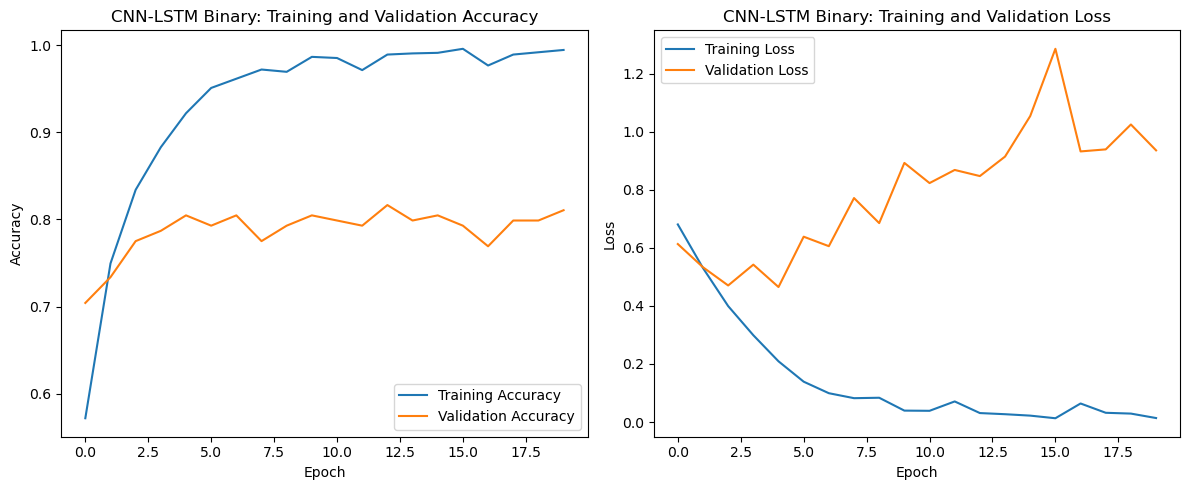


CNN-LSTM binary model built, compiled, trained, and saved.


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer


print("Starting Step 8.2: Build and Train a CNN-LSTM Model for Binary Sentiment Classification")

# --- Ensure all necessary binary parameters and data are loaded/generated ---
# This block makes the cell robust against kernel restarts and ensures we use the binary data
if 'X_train_binary' not in locals() or 'y_train_binary' not in locals() or 'embedding_matrix_binary' not in locals():
    print("Warning: Essential binary DL training data (X_train_binary, y_train_binary) or embedding_matrix_binary not found in current scope.")
    print("Attempting to re-load binary data and parameters...")
    try:
        # Define paths for binary data
        cleaned_dataset_path = os.path.join('data', 'cleaned_social_media_comments.csv')
        tokenizer_save_path_binary = os.path.join('models', 'dl_tokenizer_binary.joblib')
        dl_params_path_binary = os.path.join('models', 'dl_params_binary.joblib')
        GLOVE_DIR = os.path.join('data', 'glove')
        GLOVE_FILE = os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')
        EMBEDDING_DIM = 100

        # Load binary tokenizer and DL params
        tokenizer_binary = joblib.load(tokenizer_save_path_binary)
        dl_params_binary = joblib.load(dl_params_path_binary)
        MAX_SEQUENCE_LENGTH_binary = dl_params_binary['max_sequence_length']
        num_words_in_vocab_binary = dl_params_binary['num_words_in_vocab']
        sentiment_label_map_binary = dl_params_binary['sentiment_label_map']


        # Re-prepare X_padded_binary and y_one_hot_binary to ensure consistency
        df_cleaned = pd.read_csv(cleaned_dataset_path)
        df_binary = df_cleaned[df_cleaned['sentiment_numerical'] != 1].copy()
        df_binary['sentiment_numerical_binary'] = df_binary['sentiment_numerical'].map({0: 0, 2: 1})

        X_text_binary = df_binary['cleaned_text'].astype(str)
        y_binary = df_binary['sentiment_numerical_binary']

        X_sequences_binary = tokenizer_binary.texts_to_sequences(X_text_binary)
        X_padded_binary = pad_sequences(X_sequences_binary, maxlen=MAX_SEQUENCE_LENGTH_binary, padding='post', truncating='post')

        label_binarizer_binary = LabelBinarizer()
        y_one_hot_binary = label_binarizer_binary.fit_transform(y_binary)
        if y_one_hot_binary.shape[1] == 1:
            y_one_hot_binary = np.hstack([1 - y_one_hot_binary, y_one_hot_binary])

        # Re-split data to get X_train_binary, X_test_binary, etc.
        X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
            X_padded_binary, y_one_hot_binary, test_size=0.2, random_state=42, stratify=y_binary
        )
        print("Binary data (X_train_binary, y_train_binary etc.) re-loaded/re-prepared successfully.")

        # Re-generate embedding matrix for binary data
        embeddings_index = {}
        with open(GLOVE_FILE, encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
        print(f"Loaded {len(embeddings_index)} word vectors (re-loaded for fresh session).")

        word_index_binary = tokenizer_binary.word_index
        num_words_in_vocab_binary = min(num_words_in_vocab_binary, len(word_index_binary) + 1) # Use saved num_words_in_vocab
        embedding_matrix_binary = np.zeros((num_words_in_vocab_binary, EMBEDDING_DIM))
        for word, i in word_index_binary.items():
            if i < num_words_in_vocab_binary:
                embedding_vector = embeddings_index.get(word)
                if embedding_vector is not None:
                    embedding_matrix_binary[i] = embedding_vector
        print("Embedding matrix for binary data re-generated successfully.")

    except FileNotFoundError as fnfe:
        print(f"Fatal Error: A required file was not found: {fnfe}. Please ensure all previous steps were run and files exist.")
        exit()
    except Exception as e:
        print(f"Fatal Error during re-loading binary data for model building: {e}")
        exit()
else:
    print("Essential binary DL parameters and training data found in current scope. Proceeding directly to model building.")


# Define the number of sentiment classes (now 2: negative, positive)
NUM_CLASSES_BINARY = y_train_binary.shape[1]

# --- Build the Keras CNN-LSTM Model for Binary Classification ---
print("\nBuilding the CNN-LSTM Neural Network model for binary classification...")
model_cnn_lstm_binary = Sequential()

# Embedding Layer
model_cnn_lstm_binary.add(Embedding(
    input_dim=num_words_in_vocab_binary,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix_binary],
    input_length=MAX_SEQUENCE_LENGTH_binary,
    trainable=False
))

# 1D Convolutional Layer (from previous best try)
model_cnn_lstm_binary.add(Conv1D(
    filters=128,
    kernel_size=5,
    activation='relu'
))
model_cnn_lstm_binary.add(MaxPooling1D(
    pool_size=MAX_SEQUENCE_LENGTH_binary // 4 # Dynamic pooling based on binary data's max length
))

# Bidirectional LSTM Layer
model_cnn_lstm_binary.add(Bidirectional(LSTM(
    units=128,
    dropout=0.4,
    recurrent_dropout=0.4
)))

# Dense (Hidden) Layer
model_cnn_lstm_binary.add(Dense(
    units=64,
    activation='relu'
))
model_cnn_lstm_binary.add(Dropout(0.4))

# Output Layer (Crucial change: units=2 for binary classification)
model_cnn_lstm_binary.add(Dense(
    units=NUM_CLASSES_BINARY, # This will now be 2
    activation='softmax'      # Softmax for multi-class (even binary can use it if one-hot encoded)
))

# Compile the model
model_cnn_lstm_binary.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model_cnn_lstm_binary.summary()

# --- Train the Model ---
print("\nTraining the CNN-LSTM binary classification model... This will take a while.")

# Callbacks:
callbacks_cnn_lstm_binary = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True), # Increased patience significantly
    ModelCheckpoint(filepath=os.path.join('models', 'best_cnn_lstm_binary_sentiment_model.keras'), monitor='val_loss', save_best_only=True)
]

history_cnn_lstm_binary = model_cnn_lstm_binary.fit(
    X_train_binary,
    y_train_binary,
    epochs=100, # Increased max epochs, EarlyStopping will stop it
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks_cnn_lstm_binary,
    verbose=1
)

print("\n--- CNN-LSTM Binary Classification Model Training Complete ---")
print(f"Best model weights saved to: {os.path.join('models', 'best_cnn_lstm_binary_sentiment_model.keras')}")

# Plotting training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn_lstm_binary.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_lstm_binary.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN-LSTM Binary: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_lstm_binary.history['loss'], label='Training Loss')
plt.plot(history_cnn_lstm_binary.history['val_loss'], label='Validation Loss')
plt.title('CNN-LSTM Binary: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

print("\nCNN-LSTM binary model built, compiled, trained, and saved.")

Starting Step 8.3: Evaluate the CNN-LSTM Binary Classification Model
Binary test data (X_test_binary, y_test_binary) and sentiment_label_map_binary found in current scope. Proceeding to evaluation.
CNN-LSTM binary model loaded successfully from: models\best_cnn_lstm_binary_sentiment_model.keras

--- Evaluating the Best CNN-LSTM Binary Classification Model on Test Set ---
Overall Accuracy of CNN-LSTM Binary Model on Test Set: 0.8432
Overall Loss of CNN-LSTM Binary Model on Test Set: 0.4251

Classification Report (CNN-LSTM Binary Model):
              precision    recall  f1-score   support

    negative     0.8045    0.8850    0.8429       200
    positive     0.8856    0.8054    0.8436       221

    accuracy                         0.8432       421
   macro avg     0.8451    0.8452    0.8432       421
weighted avg     0.8471    0.8432    0.8432       421



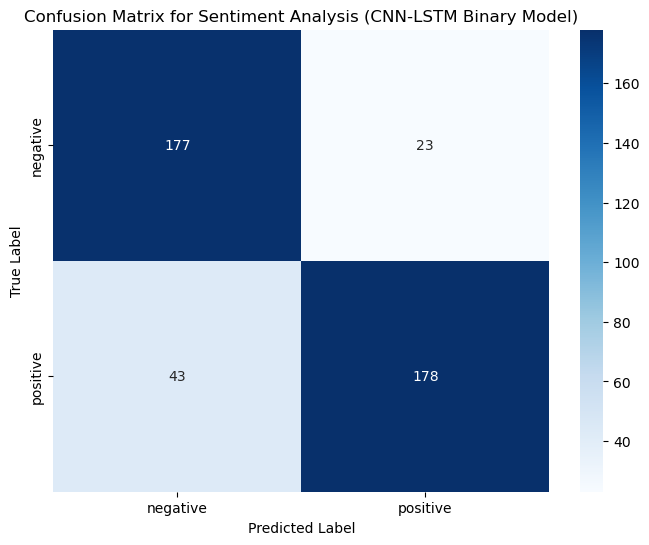


CNN-LSTM binary model evaluation complete. Review the metrics to understand performance.


In [6]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import joblib
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer


print("Starting Step 8.3: Evaluate the CNN-LSTM Binary Classification Model")

# --- Load necessary binary parameters and test data if not in current scope ---
if 'X_test_binary' not in locals() or 'y_test_binary' not in locals() or 'sentiment_label_map_binary' not in locals():
    print("Warning: X_test_binary, y_test_binary or sentiment_label_map_binary not found in current scope.")
    print("Attempting to re-load binary data and parameters for evaluation...")
    try:
        # Define paths for binary data
        cleaned_dataset_path = os.path.join('data', 'cleaned_social_media_comments.csv')
        tokenizer_save_path_binary = os.path.join('models', 'dl_tokenizer_binary.joblib')
        dl_params_path_binary = os.path.join('models', 'dl_params_binary.joblib')

        # Load binary tokenizer and DL params
        tokenizer_binary = joblib.load(tokenizer_save_path_binary)
        dl_params_binary = joblib.load(dl_params_path_binary)
        MAX_SEQUENCE_LENGTH_binary = dl_params_binary['max_sequence_length']
        sentiment_label_map_binary = dl_params_binary['sentiment_label_map']


        # Re-prepare X_padded_binary and y_one_hot_binary to ensure consistency
        df_cleaned = pd.read_csv(cleaned_dataset_path)
        df_binary = df_cleaned[df_cleaned['sentiment_numerical'] != 1].copy() # Filter where numerical sentiment is NOT 1 (neutral)
        df_binary['sentiment_numerical_binary'] = df_binary['sentiment_numerical'].map({0: 0, 2: 1}) # Remap to 0, 1

        X_text_binary = df_binary['cleaned_text'].astype(str)
        y_binary = df_binary['sentiment_numerical_binary']

        X_sequences_binary = tokenizer_binary.texts_to_sequences(X_text_binary)
        X_padded_binary = pad_sequences(X_sequences_binary, maxlen=MAX_SEQUENCE_LENGTH_binary, padding='post', truncating='post')

        label_binarizer_binary = LabelBinarizer()
        y_one_hot_binary = label_binarizer_binary.fit_transform(y_binary)
        if y_one_hot_binary.shape[1] == 1:
            y_one_hot_binary = np.hstack([1 - y_one_hot_binary, y_one_hot_binary])

        # Re-split data to get X_test_binary and y_test_binary
        _, X_test_binary, _, y_test_binary = train_test_split(
            X_padded_binary, y_one_hot_binary, test_size=0.2, random_state=42, stratify=y_binary
        )
        print("Binary test data (X_test_binary, y_test_binary) and sentiment_label_map_binary re-loaded successfully.")
    except FileNotFoundError as fnfe:
        print(f"Fatal Error: A required file was not found for evaluation: {fnfe}. Please ensure all previous steps were run and files exist.")
        exit()
    except Exception as e:
        print(f"Fatal Error during re-loading binary data for evaluation: {e}")
        exit()
else:
    print("Binary test data (X_test_binary, y_test_binary) and sentiment_label_map_binary found in current scope. Proceeding to evaluation.")


# Load the best trained CNN-LSTM binary model
model_load_path_cnn_lstm_binary = os.path.join('models', 'best_cnn_lstm_binary_sentiment_model.keras')
try:
    best_cnn_lstm_binary_model = load_model(model_load_path_cnn_lstm_binary)
    print(f"CNN-LSTM binary model loaded successfully from: {model_load_path_cnn_lstm_binary}")
except Exception as e:
    print(f"Error: Could not load the saved CNN-LSTM binary model from {model_load_path_cnn_lstm_binary}. Please ensure the model was saved correctly in Step 8.2.")
    print(f"Error details: {e}")
    exit()

print("\n--- Evaluating the Best CNN-LSTM Binary Classification Model on Test Set ---")

# Evaluate the model on the test set
loss_cnn_lstm_binary, accuracy_cnn_lstm_binary = best_cnn_lstm_binary_model.evaluate(X_test_binary, y_test_binary, verbose=0)
print(f"Overall Accuracy of CNN-LSTM Binary Model on Test Set: {accuracy_cnn_lstm_binary:.4f}")
print(f"Overall Loss of CNN-LSTM Binary Model on Test Set: {loss_cnn_lstm_binary:.4f}")

# Make predictions
y_pred_proba_cnn_lstm_binary = best_cnn_lstm_binary_model.predict(X_test_binary, verbose=0)
y_pred_cnn_lstm_binary = np.argmax(y_pred_proba_cnn_lstm_binary, axis=1) # Convert probabilities to class labels (0, 1)
y_true_cnn_lstm_binary = np.argmax(y_test_binary, axis=1) # Convert one-hot encoded true labels back to class labels

print("\nClassification Report (CNN-LSTM Binary Model):")
# Map numerical labels to string names for the classification report
target_names_binary_list = [sentiment_label_map_binary[i] for i in sorted(sentiment_label_map_binary.keys())]
unique_labels_true_binary = np.unique(y_true_cnn_lstm_binary)
unique_labels_pred_binary = np.unique(y_pred_cnn_lstm_binary)
all_unique_labels_binary = sorted(np.unique(np.concatenate((unique_labels_true_binary, unique_labels_pred_binary))))
filtered_target_names_binary = [target_names_binary_list[i] for i in all_unique_labels_binary]


print(classification_report(y_true_cnn_lstm_binary, y_pred_cnn_lstm_binary, target_names=filtered_target_names_binary, digits=4))

# Plotting the Confusion Matrix
cm_cnn_lstm_binary = confusion_matrix(y_true_cnn_lstm_binary, y_pred_cnn_lstm_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn_lstm_binary, annot=True, fmt='d', cmap='Blues', xticklabels=filtered_target_names_binary, yticklabels=filtered_target_names_binary)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Sentiment Analysis (CNN-LSTM Binary Model)')
plt.show()

print("\nCNN-LSTM binary model evaluation complete. Review the metrics to understand performance.")